In [166]:
import pandas as pd
import numpy as np
import random
from collections import Counter




In [226]:
def read_dat_data(path):
    

 mydata = pd.read_csv(path, delimiter="::", header=0)
 mydata = mydata.drop(mydata.index[-1])
 mydata.columns=['user_id', 'movie_id','rating','timestamp']
 
 return(mydata)




def read_csv_data(path):
    

  mydata = pd.read_csv(path, delimiter=",")
  mydata.columns=['user_id', 'movie_id','rating','timestamp']
 
  return(mydata)




mydata=read_dat_data("/home/ahmedaa/Desktop/ml-1m/ratings.dat")  

/tmp/ipykernel_6923/1738290370.py:4: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  mydata = pd.read_csv(path, delimiter="::", header=0)


In [207]:
mydata

user_id  movie_id  rating  timestamp
0              1       661       3  978302109
1              1       914       3  978301968
2              1      3408       4  978300275
3              1      2355       5  978824291
4              1      1197       3  978302268
...          ...       ...     ...        ...
1000202     6040      1090       3  956715518
1000203     6040      1091       1  956716541
1000204     6040      1094       5  956704887
1000205     6040       562       5  956704746
1000206     6040      1096       4  956715648

[1000207 rows x 4 columns]

6+3

In [208]:
len(mydata)

1000207

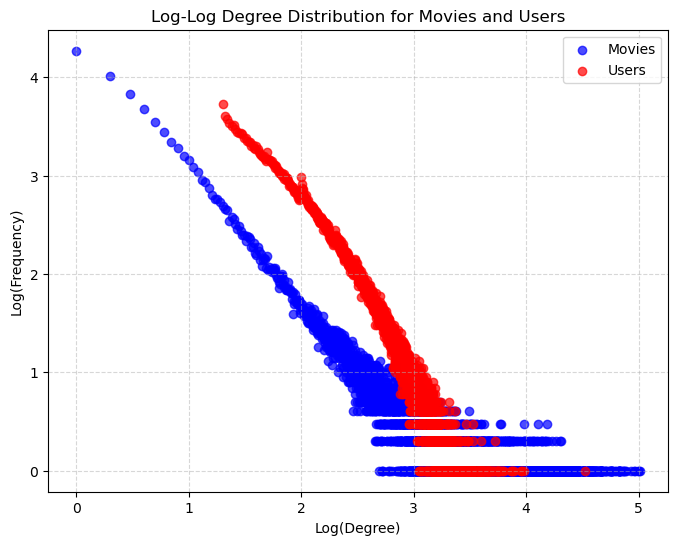

In [209]:
#Degree distribution plot
import matplotlib.pyplot as plt
import numpy as np

movies_degrees = Counter(movies)
movies_degrees_frequency=Counter(movies_degrees.values())



users_degrees = Counter(users)
users_degrees_frequency=Counter(users_degrees.values())

x_movies = np.log10(list(movies_degrees_frequency.keys()))
y_movies = np.log10(list(movies_degrees_frequency.values()))


x_users = np.log10(list(users_degrees_frequency.keys()))
y_users = np.log10(list(users_degrees_frequency.values()))

# Plotting
plt.figure(figsize=(8, 6))
plt.scatter(x_movies, y_movies, color='blue', label='Movies', alpha=0.7)
plt.scatter(x_users, y_users, color='red', label='Users', alpha=0.7)

# Add labels, title, and legend
plt.xlabel('Log(Degree)')
plt.ylabel('Log(Frequency)')
plt.title('Log-Log Degree Distribution for Movies and Users')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.savefig('degree_distribution.pdf', format='pdf', bbox_inches='tight')
plt.show()

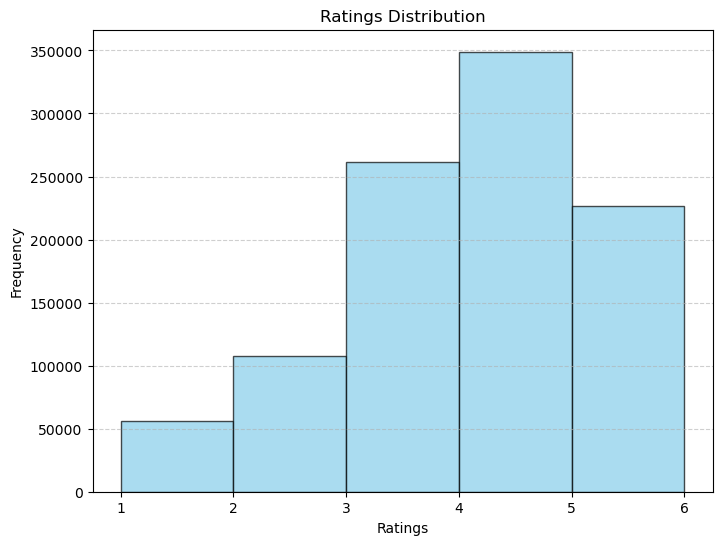

In [210]:
import matplotlib.pyplot as plt
import numpy as np

# Example: Replace `mydata['ratings']` with your actual ratings data
ratings = mydata['rating']

# Define bins for the range 1-5 with step size 1
bins = np.arange(1, 5 + 2)  # Creates bin edges: [1, 2, 3, 4, 5]

# Plotting the histogram
plt.figure(figsize=(8, 6))
plt.hist(ratings, bins=bins, color='skyblue', edgecolor='black', alpha=0.7)

# Adding labels and title
plt.xlabel('Ratings')
plt.ylabel('Frequency')
plt.title('Ratings Distribution')
plt.xticks(bins)  # Set x-axis ticks to match the bin edges
plt.grid(axis='y', linestyle='--', alpha=0.6)

# Save the plot as a PDF file
plt.savefig('ratings_distribution.pdf', format='pdf', bbox_inches='tight')

# Display the plot
plt.show()


In [183]:
import numpy as np
import time
import pandas as pd

def initialize_latent_matrices(n_users, n_movies, k):
    """
    Initialize latent factor matrices for users and movies.
    """
    U = np.random.rand(n_users, k)
    V = np.random.rand(n_movies, k)
    return U, V

def create_id_mappings(data):
    """
    Create mappings from user IDs and movie IDs to indices.
    """
    map_user_to_index = dict(zip(data['user_id'].unique(), range(len(data['user_id'].unique()))))
    map_movie_to_index = dict(zip(data['movie_id'].unique(), range(len(data['movie_id'].unique()))))
    return map_user_to_index, map_movie_to_index

def split_data(data, user_map, movie_map, train_ratio=0.9):
    """
    Split the dataset into training and testing sets by user and movie indices.
    """
    # Initialize training and testing data structures
    train_data_by_user = [[] for _ in range(len(user_map))]
    test_data_by_user = [[] for _ in range(len(user_map))]
    train_data_by_movie = [[] for _ in range(len(movie_map))]
    test_data_by_movie = [[] for _ in range(len(movie_map))]

    # Split the data
    for _, user_id, movie_id, rating, _ in data.itertuples():
        r = np.random.uniform()
        if r < train_ratio:
            train_data_by_user[user_map[user_id]].append((movie_id, rating))
            train_data_by_movie[movie_map[movie_id]].append((user_id, rating))
        else:
            test_data_by_user[user_map[user_id]].append((movie_id, rating))
            test_data_by_movie[movie_map[movie_id]].append((user_id, rating))

    return train_data_by_user, test_data_by_user, train_data_by_movie, test_data_by_movie

def measure_execution_time(func, *args, **kwargs):
    """
    Measure and print the execution time of a function.
    """
    start_time = time.time()
    result = func(*args, **kwargs)
    elapsed_time = time.time() - start_time
    print(f"Elapsed time: {elapsed_time:.2f} seconds")
    return result


 
    n_users = len(data['user_id'].unique())
    n_movies = len(data['movie_id'].unique())
    k = 10  # Number of latent features

    # Initialize latent factor matrices
    U, V = initialize_latent_matrices(n_users, n_movies, k)

    # Create ID mappings
    user_map, movie_map = create_id_mappings(data)

    # Split data and measure execution time
    train_data_by_user, test_data_by_user, train_data_by_movie, test_data_by_movie = measure_execution_time(
        split_data, data, user_map, movie_map
    )

    print("Data splitting completed.")


Elapsed time: 0.01 seconds
Data splitting completed.


In [219]:
iterations=10

In [221]:
def grid_search(train_data_by_user_index, train_data_by_movie_index, test_data_by_user_index,
                map_movie_to_index, map_user_to_index, n, m, k, iterations, lambdaa_values, gamma_values, tau_values):
    """
    Perform a grid search over lambdaa, gamma, and tau values to find the optimal RMSE on the testing set.
    
    Parameters:
    - train_data_by_user_index: Training data grouped by user.
    - train_data_by_movie_index: Training data grouped by movie.
    - test_data_by_user_index: Testing data grouped by user.
    - map_movie_to_index: Mapping of movie IDs to indices.
    - map_user_to_index: Mapping of user IDs to indices.
    - n: Number of users.
    - m: Number of movies.
    - k: Number of latent factors.
    - iterations: Number of training iterations.
    - lambdaa_values: List of lambdaa values to try.
    - gamma_values: List of gamma values to try.
    - tau_values: List of tau values to try.
    
    Returns:
    - results: A list of tuples with (lambdaa, gamma, tau, best_test_RMSE).
    """
    results = []
    best_config = None
    best_test_RMSE = float('inf')

    for lambdaa in lambdaa_values:
        for gamma in gamma_values:
            for tau in tau_values:
                print(f"Testing configuration: lambdaa={lambdaa}, gamma={gamma}, tau={tau}")
                
                # Train the model with the current hyperparameters
                _, _, _, _, _, test_RMSES, _, _ = train_model(
                    iterations, n, m, k,
                    train_data_by_user_index, train_data_by_movie_index,
                    test_data_by_user_index,
                    map_movie_to_index, map_user_to_index,
                    lambdaa, gamma, tau
                )
                
                # Get the RMSE for the last iteration
                final_test_RMSE = test_RMSES[-1]
                results.append((lambdaa, gamma, tau, final_test_RMSE))
                
                # Update the best configuration if necessary
                if final_test_RMSE < best_test_RMSE:
                    best_test_RMSE = final_test_RMSE
                    best_config = (lambdaa, gamma, tau)

                print(f"Final test RMSE for this configuration: {final_test_RMSE:.4f}")
    
    print(f"Best configuration: lambdaa={best_config[0]}, gamma={best_config[1]}, tau={best_config[2]} with RMSE={best_test_RMSE:.4f}")
    return results, best_config

# Example usage:
lambdaa_values = [0.001, 0.01, 0.1, 1]
gamma_values = [0.001, 0.01, 0.1, 1]
tau_values = [0.001, 0.01, 0.1, 1]

# Perform the grid search
results, best_config = grid_search(
    train_data_by_user_index, train_data_by_movie_index, test_data_by_user_index,
    map_movie_to_index, map_user_to_index, n, m, k, iterations,
    lambdaa_values, gamma_values, tau_values
)

# Display all results
print("All Results:")
for lambdaa, gamma, tau, test_RMSE in results:
    print(f"lambdaa={lambdaa}, gamma={gamma}, tau={tau} -> Test RMSE={test_RMSE:.4f}")


Testing configuration: lambdaa=0.001, gamma=0.001, tau=0.001
Iteration 1/10
Elapsed time: 2.48 seconds
Iteration 1 Train RMSE: 0.8704, Test RMSE: 0.9579
Iteration 2/10
Elapsed time: 4.98 seconds
Iteration 2 Train RMSE: 0.8101, Test RMSE: 0.9280
Iteration 3/10
Elapsed time: 7.49 seconds
Iteration 3 Train RMSE: 0.7848, Test RMSE: 0.9101
Iteration 4/10
Elapsed time: 9.92 seconds
Iteration 4 Train RMSE: 0.7722, Test RMSE: 0.8997
Iteration 5/10
Elapsed time: 12.39 seconds
Iteration 5 Train RMSE: 0.7647, Test RMSE: 0.8923
Iteration 6/10
Elapsed time: 14.85 seconds
Iteration 6 Train RMSE: 0.7597, Test RMSE: 0.8868
Iteration 7/10
Elapsed time: 17.31 seconds
Iteration 7 Train RMSE: 0.7564, Test RMSE: 0.8830
Iteration 8/10
Elapsed time: 19.92 seconds
Iteration 8 Train RMSE: 0.7542, Test RMSE: 0.8803
Iteration 9/10
Elapsed time: 22.38 seconds
Iteration 9 Train RMSE: 0.7525, Test RMSE: 0.8783
Iteration 10/10
Elapsed time: 25.04 seconds
Iteration 10 Train RMSE: 0.7513, Test RMSE: 0.8767
Training co

In [222]:
best_config

(0.01, 0.001, 0.1)

In [224]:
def train_regular_model(n, m, k, iterations, train_data_by_user_index, train_data_by_movie_index, test_data_by_user_index,
                        map_movie_to_index, map_user_to_index, lambdaa, gamma, tau):
    """
    Train the regular model with fixed hyperparameters and evaluate RMSE on both train and test data.

    Parameters:
    - n: Number of users.
    - m: Number of movies.
    - k: Number of latent factors.
    - iterations: Number of iterations to train.
    - train_data_by_user_index: Training data grouped by user.
    - train_data_by_movie_index: Training data grouped by movie.
    - test_data_by_user_index: Testing data grouped by user.
    - map_movie_to_index: Mapping of movie IDs to indices.
    - map_user_to_index: Mapping of user IDs to indices.
    - lambdaa: Regularization parameter for bias updates.
    - gamma: Regularization parameter for bias updates.
    - tau: Regularization parameter for factor updates.

    Returns:
    - U, V, user_biases, item_biases, train_RMSES, test_RMSES
    """
    print(f"Training model with parameters: k={k}, lambda={lambdaa}, gamma={gamma}, tau={tau}")

    # Train the model
    U, V, user_biases, item_biases, train_RMSES, test_RMSES, _ = train_model(
        iterations, n, m, k,
        train_data_by_user_index, train_data_by_movie_index, test_data_by_user_index,
        map_movie_to_index, map_user_to_index, lambdaa, gamma, tau
    )

    # Plot RMSE
    plt.figure(figsize=(8, 6))
    plt.plot(range(len(train_RMSES)), train_RMSES, label='Train RMSE', color='blue')
    plt.plot(range(len(test_RMSES)), test_RMSES, label='Test RMSE', color='red')
    plt.xlabel("Iterations")
    plt.ylabel("RMSE")
    plt.title(f"RMSE over Iterations (k={k}, lambda={lambdaa}, gamma={gamma}, tau={tau})")
    plt.legend()
    plt.grid()
    plt.savefig("regular_model_rmse.pdf")
    plt.show()

    return U, V, user_biases, item_biases, train_RMSES, test_RMSES


iterations = 20
lambdaa = 0.01
gamma = 0.001
tau = 0.1

# Train the model with fixed parameters
U, V, user_biases, item_biases, train_RMSES, test_RMSES = train_regular_model(
    n, m, k, iterations,
    train_data_by_user_index, train_data_by_movie_index, test_data_by_user_index,
    map_movie_to_index, map_user_to_index,
    lambdaa, gamma, tau
)


Training model with parameters: k=10, lambda=0.01, gamma=0.001, tau=0.1
Iteration 1/20
Elapsed time: 2.62 seconds
Iteration 1 Train RMSE: 0.8915, Test RMSE: 0.9336
Iteration 2/20
Elapsed time: 5.17 seconds
Iteration 2 Train RMSE: 0.8256, Test RMSE: 0.8882
Iteration 3/20
Elapsed time: 7.74 seconds
Iteration 3 Train RMSE: 0.8004, Test RMSE: 0.8677
Iteration 4/20
Elapsed time: 10.47 seconds
Iteration 4 Train RMSE: 0.7899, Test RMSE: 0.8584
Iteration 5/20
Elapsed time: 13.02 seconds
Iteration 5 Train RMSE: 0.7844, Test RMSE: 0.8530
Iteration 6/20
Elapsed time: 15.56 seconds
Iteration 6 Train RMSE: 0.7811, Test RMSE: 0.8496
Iteration 7/20
Elapsed time: 18.00 seconds
Iteration 7 Train RMSE: 0.7791, Test RMSE: 0.8474
Iteration 8/20
Elapsed time: 20.60 seconds
Iteration 8 Train RMSE: 0.7778, Test RMSE: 0.8459
Iteration 9/20
Elapsed time: 23.14 seconds
Iteration 9 Train RMSE: 0.7770, Test RMSE: 0.8450
Iteration 10/20
Elapsed time: 25.63 seconds
Iteration 10 Train RMSE: 0.7764, Test RMSE: 0.8444

ValueError: too many values to unpack (expected 7)

In [229]:
def train_models_and_plot_rmse_vs_k(n, m, iterations, k_values, train_data_by_user_index, train_data_by_movie_index, 
                                    test_data_by_user_index, map_movie_to_index, map_user_to_index, lambdaa, gamma, tau):
    """
    Train models with different values of k (latent factors) and plot test RMSE vs. k.

    Parameters:
    - n, m: Number of users and movies.
    - iterations: Number of training iterations.
    - k_values: List of latent factor dimensions to test.
    - train_data_by_user_index, train_data_by_movie_index: Training data grouped by user and movie.
    - test_data_by_user_index: Testing data grouped by user.
    - map_movie_to_index, map_user_to_index: Mappings for movie and user IDs to indices.
    - lambdaa, gamma, tau: Regularization parameters.

    Returns:
    - test_rmse_per_k: Dictionary mapping k values to their corresponding final test RMSE.
    """
    test_rmse_per_k = {}

    for k in k_values:
        print(f"\nTraining model with k={k} latent factors...")
        _, _, _, _, test_RMSES, _ = train_full_model(
            iterations, n, m, k, train_data_by_user_index, train_data_by_movie_index,
            test_data_by_user_index, map_movie_to_index, map_user_to_index, lambdaa, gamma, tau
        )
        final_test_rmse = test_RMSES[-1]
        test_rmse_per_k[k] = final_test_rmse
        print(f"Final Test RMSE for k={k}: {final_test_rmse:.4f}")

    # Plot Test RMSE vs. k
    plt.figure(figsize=(8, 6))
    plt.plot(k_values, [test_rmse_per_k[k] for k in k_values], marker='o', color='blue', label="Test RMSE")
    plt.xlabel("Number of Latent Factors (k)")
    plt.ylabel("Test RMSE")
    plt.title("Test RMSE vs. Number of Latent Factors (k)")
    plt.grid()
    plt.legend()
    plt.savefig("test_rmse_vs_k.pdf")  # Save the plot as a PDF
    plt.show()

    return test_rmse_per_k


iterations = 10
k_values = [2, 4, 8, 16, 32]  # Different values of k to test
lambdaa = 0.01
gamma = 0.001
tau = 0.1

# Train models with different values of k and plot RMSE vs. k
test_rmse_results = train_models_and_plot_rmse_vs_k(
    n, m, iterations, k_values,
    train_data_by_user_index, train_data_by_movie_index, test_data_by_user_index,
    map_movie_to_index, map_user_to_index, lambdaa, gamma, tau
)

# Display results
print("\nTest RMSE for Different Values of k:")
for k, test_rmse in test_rmse_results.items():
    print(f"k={k}: Test RMSE={test_rmse:.4f}")



Training model with k=2 latent factors...


NameError: name 'train_full_model' is not defined

In [227]:

import time

#

n=len(mydata['user_id'].unique())
m=len(mydata['movie_id'].unique())




U = np.random.rand(n, k)
V = np.random.rand(m, k)


tic = time.time()



map_user_to_index = dict(zip(mydata['user_id'].unique(), range(len(mydata))))
map_movie_to_index = dict(zip(mydata['movie_id'].unique(), range(len(mydata))))

train_data_by_user_index = [[] for _ in range(len(map_user_to_index))]
test_data_by_user_index=[[] for _ in range(len(map_user_to_index))]


train_data_by_movie_index = [[] for _ in range(len(map_movie_to_index))]
test_data_by_movie_index=[[] for _ in range(len(map_movie_to_index))]



for _, userId, movieId, rating, _ in mydata.itertuples():
    r = np.random.uniform(size=1)[0]
    if(r<0.90):
     train_data_by_user_index[map_user_to_index[userId]].append((movieId,rating))
     train_data_by_movie_index[map_movie_to_index[movieId]].append((userId,rating))
    else:
     test_data_by_user_index[map_user_to_index[userId]].append((movieId,rating))
     test_data_by_movie_index[map_movie_to_index[movieId]].append((userId,rating))



# for i in range(len(df)):
#    r = np.random.uniform(size=1)[0]
#    if(r<0.95):
#     train_data_by_user_index[map_user_to_index[df.iloc[i][0]]].append((df.iloc[i][1],df.iloc[i][2]))
#     #test_data_by_user_index[map_user_to_index[df.iloc[i][0]]].append([])

#     train_data_by_movie_index[map_movie_to_index[df.iloc[i][1]]].append((df.iloc[i][0],df.iloc[i][2]))
#     #test_data_by_movie_index[map_movie_to_index[df.iloc[i][1]]].append([])

#    else:
#     test_data_by_user_index[map_user_to_index[df.iloc[i][0]]].append((df.iloc[i][1],df.iloc[i][2]))
#     #train_data_by_user_index[map_user_to_index[df.iloc[i][0]]].append([])

#     test_data_by_movie_index[map_movie_to_index[df.iloc[i][1]]].append((df.iloc[i][0],df.iloc[i][2]))
#     #train_data_by_movie_index[map_movie_to_index[df.iloc[i][1]]].append([])

# #   data_by_user_index[map_user_to_index[df.iloc[i]['userId']]].append((df.iloc[i]['movieId'],df.iloc[i]['rating']))
# #   data_by_movie_index[map_movie_to_index[df.iloc[i]['movieId']]].append((df.iloc[i]['userId'],df.iloc[i]['rating']))




# for i in range(len(df)):
#   r = np.random.uniform(size=1)[0]
#   if(r<0.9):
#    data_by_user_train[map_user_to_index[df.iloc[i][0]]][map_movie_to_index[df.iloc[i][1]]]=df.iloc[i][2]
#    data_by_movie_train[map_movie_to_index[df.iloc[i][1]]][map_user_to_index[df.iloc[i][0]]]=df.iloc[i][2]

#   else:
#    data_by_user_test[map_user_to_index[df.iloc[i][0]]][map_movie_to_index[df.iloc[i][1]]]=df.iloc[i][2]
#    data_by_movie_test[map_movie_to_index[df.iloc[i][1]]][map_user_to_index[df.iloc[i][0]]]=df.iloc[i][2]

print("Donee")



# Code to measure

# Stop timer (toc)
toc = time.time()

# Calculate elapsed time
elapsed_time = toc - tic
print(f"Elapsed time: {elapsed_time:.2f} seconds")



Donee
Elapsed time: 4.73 seconds


doneeeeeeeeeeee


In [ ]:
train_data_by_user_index

In [153]:
print(i)

5778609


In [212]:
#Vectorized biases only

import matplotlib.pyplot as plt
import numpy as np
import time

def initialize_biases_matrices(n, m):
 
    user_biases = np.zeros(n)
    item_biases = np.zeros(m)
    return user_biases, item_biases

def update_user_biases(user_biases, item_biases, train_data_by_user_index, lambdaa, gamma, map_movie_to_index):
    for i, rated_by_user in enumerate(train_data_by_user_index):
        if len(rated_by_user) == 0:
            continue

        movie_indices = [map_movie_to_index[movie_id] for movie_id, _ in rated_by_user]
        ratings = np.array([rating for _, rating in rated_by_user])
        V_rated = V[movie_indices]
        user_biases[i] = np.sum(lambdaa * (ratings - item_biases[movie_indices])) / (lambdaa * len(rated_by_user) + gamma)


def update_item_biases(user_biases, item_biases, train_data_by_movie_index, lambdaa, gamma, map_user_to_index):
    for j, watched_by_users in enumerate(train_data_by_movie_index):
        if len(watched_by_users) == 0:
            continue

        user_indices = [map_user_to_index[user_id] for user_id, _ in watched_by_users]
        ratings = np.array([rating for _, rating in watched_by_users])
        item_biases[j] = np.sum(lambdaa * (ratings - user_biases[user_indices])) / (lambdaa * len(watched_by_users) + gamma)



def compute_metrics(user_biases, item_biases, test_data_by_user_index, map_movie_to_index, gamma):
    RMSE = 0
    C = 0
    counter = 0

    for i, test_data in enumerate(test_data_by_user_index):
        if len(test_data) == 0:
            continue

        movie_indices = [map_movie_to_index[movie_id] for movie_id, _ in test_data]
        ratings = np.array([rating for _, rating in test_data])
        preds = user_biases[i] + item_biases[movie_indices]
        residuals = ratings - preds

        RMSE += np.sum(residuals**2)
        C -= 0.5 * gamma * (np.sum(residuals**2) + np.sum(user_biases[i]**2) + np.sum(item_biases[movie_indices]**2))
        counter += len(test_data)

    return (RMSE / counter)**0.5, C

def train_biases_model(iterations, n, m, train_data_by_user_index, train_data_by_movie_index, test_data_by_user_index, map_movie_to_index, map_user_to_index, lambdaa, gamma, tau):
    user_biases, item_biases = initialize_biases_matrices(n, m)
    costs = np.zeros(iterations)
    RMSES = np.zeros(iterations)

    tic = time.time()
    for r in range(iterations):
        print(f"Iteration {r + 1}/{iterations}")
        update_user_biases(user_biases, item_biases, train_data_by_user_index, lambdaa, gamma, map_movie_to_index)
        update_item_biases(user_biases, item_biases, train_data_by_movie_index, lambdaa, gamma, map_user_to_index)

        RMSE, C = compute_metrics(user_biases, item_biases, test_data_by_user_index, map_movie_to_index, gamma)
        costs[r] = C
        RMSES[r] = RMSE

        elapsed_time = time.time() - tic
        print(f"Elapsed time: {elapsed_time:.2f} seconds")
        print(f"Iteration {r + 1} RMSE: {RMSE:.4f}")

    print("Training complete!")
    plt.plot(range(len(RMSES)), RMSES)
    plt.xlabel("Iterations")
    plt.ylabel("RMSE")
    plt.title("RMSE Over Iterations")
    plt.show()
    return user_biases, item_biases, RMSES, costs

# Example usage (assuming data and mappings are provided):
# train_model(iterations, n, m, k, train_data_by_user_index, train_data_by_movie_index, test_data_by_user_index, map_movie_to_index, map_user_to_index, lambdaa, gamma, tau)


Iteration 1/10
Elapsed time: 1.14 seconds
Iteration 1 Train RMSE: 0.9186, Test RMSE: 0.9300
Iteration 2/10
Elapsed time: 2.25 seconds
Iteration 2 Train RMSE: 0.8982, Test RMSE: 0.9090
Iteration 3/10
Elapsed time: 3.35 seconds
Iteration 3 Train RMSE: 0.8973, Test RMSE: 0.9079
Iteration 4/10
Elapsed time: 4.46 seconds
Iteration 4 Train RMSE: 0.8972, Test RMSE: 0.9078
Iteration 5/10
Elapsed time: 5.60 seconds
Iteration 5 Train RMSE: 0.8972, Test RMSE: 0.9078
Iteration 6/10
Elapsed time: 6.70 seconds
Iteration 6 Train RMSE: 0.8972, Test RMSE: 0.9078
Iteration 7/10
Elapsed time: 7.82 seconds
Iteration 7 Train RMSE: 0.8972, Test RMSE: 0.9078
Iteration 8/10
Elapsed time: 8.94 seconds
Iteration 8 Train RMSE: 0.8972, Test RMSE: 0.9078
Iteration 9/10
Elapsed time: 10.04 seconds
Iteration 9 Train RMSE: 0.8972, Test RMSE: 0.9078
Iteration 10/10
Elapsed time: 11.16 seconds
Iteration 10 Train RMSE: 0.8972, Test RMSE: 0.9078
Training complete!
Plot saved as rmse_plot.pdf


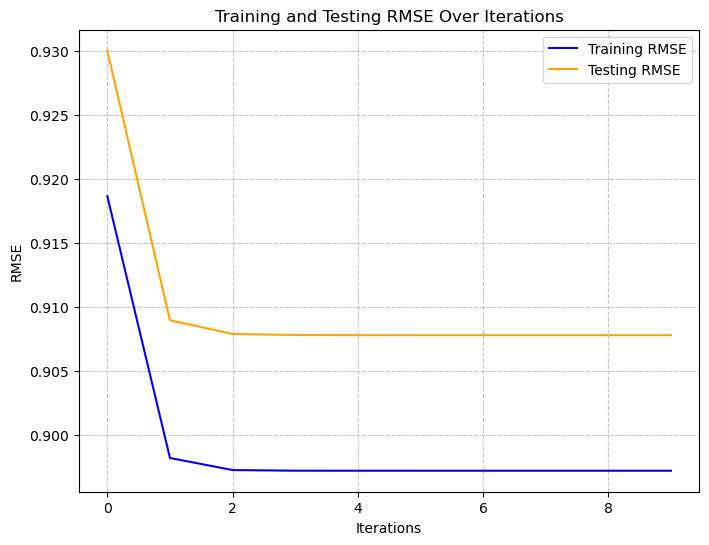

In [213]:
lambdaa=5
gamma=0.2
tau=0.1
k=10
user_biases , item_biases, RMSES,costs = train_biases_model_with_rmse_plot(iterations=10, n=n, m=m, train_data_by_user_index=train_data_by_user_index, train_data_by_movie_index=train_data_by_movie_index, test_data_by_user_index=test_data_by_user_index, map_movie_to_index=map_movie_to_index, map_user_to_index=map_user_to_index, lambdaa=lambdaa, gamma=gamma, tau=tau)


In [199]:
import matplotlib.pyplot as plt
import numpy as np
import time

def train_biases_model_with_rmse_plot(iterations, n, m, train_data_by_user_index, train_data_by_movie_index, 
                                      test_data_by_user_index, map_movie_to_index, map_user_to_index, lambdaa, gamma, tau, pdf_filename="rmse_plot.pdf"):
    user_biases, item_biases = initialize_biases_matrices(n, m)
    train_RMSES = np.zeros(iterations)
    test_RMSES = np.zeros(iterations)

    tic = time.time()
    for r in range(iterations):
        print(f"Iteration {r + 1}/{iterations}")
        update_user_biases(user_biases, item_biases, train_data_by_user_index, lambdaa, gamma, map_movie_to_index)
        update_item_biases(user_biases, item_biases, train_data_by_movie_index, lambdaa, gamma, map_user_to_index)

        # Compute RMSE for training and testing
        train_RMSE, _ = compute_metrics(user_biases, item_biases, train_data_by_user_index, map_movie_to_index, gamma)
        test_RMSE, _ = compute_metrics(user_biases, item_biases, test_data_by_user_index, map_movie_to_index, gamma)

        train_RMSES[r] = train_RMSE
        test_RMSES[r] = test_RMSE

        elapsed_time = time.time() - tic
        print(f"Elapsed time: {elapsed_time:.2f} seconds")
        print(f"Iteration {r + 1} Train RMSE: {train_RMSE:.4f}, Test RMSE: {test_RMSE:.4f}")

    print("Training complete!")

    # Plot RMSE for training and testing
    plt.figure(figsize=(8, 6))
    plt.plot(range(len(train_RMSES)), train_RMSES, label="Training RMSE", color="blue")
    plt.plot(range(len(test_RMSES)), test_RMSES, label="Testing RMSE", color="orange")
    plt.xlabel("Iterations")
    plt.ylabel("RMSE")
    plt.title("Training and Testing RMSE Over Iterations")
    plt.legend()
    plt.grid(True, linestyle="--", alpha=0.7)

    # Save the plot as a PDF
    plt.savefig("biases_only_rmses", format='pdf')
    print(f"Plot saved as {pdf_filename}")

    # Display the plot
    plt.show()

    return user_biases, item_biases, train_RMSES, test_RMSES


0
Elapsed time: 792.28 seconds
1
Elapsed time: 783.15 seconds
2
Elapsed time: 765.81 seconds
3
Elapsed time: 793.30 seconds
4
Elapsed time: 804.88 seconds
5
Elapsed time: 772.48 seconds
6
Elapsed time: 790.60 seconds
7
Elapsed time: 785.09 seconds
8
Elapsed time: 798.91 seconds
9
Elapsed time: 790.42 seconds
5alaaaaaaaaaaAAAaaaaaaaaas!


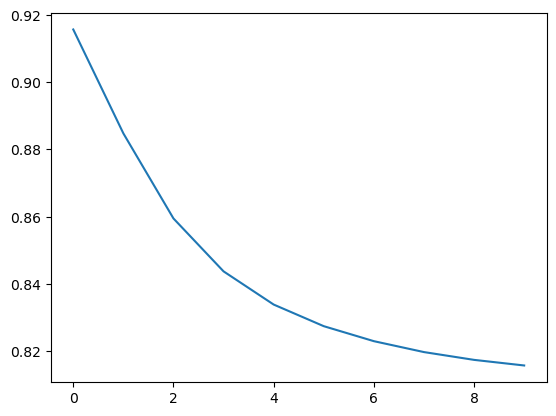

In [11]:
#Working one ^_____^
k=10
iterations=10


U = np.random.normal(0, 1/(k**0.5), (n, k))
V = np.random.normal(0, 1/(k**0.5), (m, k))

#Testing with Koffi


costs=np.zeros(iterations)
RMSES=np.zeros(iterations)

lambdaa=5
gamma=0.2
tau=0.1

user_biases=np.zeros(n)
item_biases=np.zeros(m)

for r in range(iterations):
  tic=time.time()
  print(r)
  for i in range(n):
    bias=0
    item_counter=0
    rated_by_user=train_data_by_user_index[i].copy()
    u=U[i].copy()

    for l in range(len(rated_by_user)):
      v=V[map_movie_to_index[rated_by_user[l][0]]].copy()
      bias=bias+lambdaa*(rated_by_user[l][1]-np.inner(u,v)-item_biases[map_movie_to_index[rated_by_user[l][0]]])
      item_counter=item_counter+1
    bias=bias/(lambdaa*item_counter+gamma)
    user_biases[i]=bias



    S = np.zeros(shape=(k, k))
    R = np.zeros(shape=(k, 1))
    I = tau*np.identity(k)
    for l in range(len(rated_by_user)):
      v=V[map_movie_to_index[rated_by_user[l][0]]].copy()
      v=np.asmatrix(v)
      v=v.reshape(k,1)
      S=S+lambdaa*np.matmul(v,np.transpose(v))
      R=R+lambdaa*v*(rated_by_user[l][1]-user_biases[i]-item_biases[map_movie_to_index[rated_by_user[l][0]]])
    U[i]=np.transpose(np.matmul(np.linalg.inv(S+I),R))


  for i in range(m):
    bias=0
    user_counter=0
    v=V[i].copy()
    watched_by_user=train_data_by_movie_index[i].copy()

    for l in range(len(watched_by_user)):
      u=U[map_user_to_index[watched_by_user[l][0]]].copy()
      bias=bias+lambdaa*(watched_by_user[l][1]-np.inner(u,v)-user_biases[map_user_to_index[watched_by_user[l][0]]])
      user_counter=user_counter+1
    bias=bias/(lambdaa*user_counter+gamma)
    item_biases[i]=bias



    S = np.zeros(shape=(k, k))
    R = np.zeros(shape=(k, 1))
    I = tau*np.identity(k)
    for l in range(len(watched_by_user)):
      u=U[map_user_to_index[watched_by_user[l][0]]].copy()
      u=np.asmatrix(u)
      u=u.reshape(k,1)
      S=S+lambdaa*np.matmul(u,np.transpose(u))
      R=R+lambdaa*u*(watched_by_user[l][1]-user_biases[map_user_to_index[watched_by_user[l][0]]]-item_biases[i])
    V[i]=np.transpose(np.matmul(np.linalg.inv(S+I),R))


  toc = time.time()
  elapsed_time = toc - tic
  print(f"Elapsed time: {elapsed_time:.2f} seconds")
  RMSE=0
  C=0
  counter=0
  for i in range(len(test_data_by_user_index)):
    for j in range(len(test_data_by_user_index[i])):
      rr=test_data_by_user_index[i][j][1]
      mm=map_movie_to_index[test_data_by_user_index[i][j][0]]
      RMSE=RMSE+((rr-(np.inner(U[i],V[mm])+user_biases[i]+item_biases[mm]))**2)
      counter=counter+1
      C=C-0.5*gamma*((rr-np.inner(U[i],V[mm])-user_biases[i]-item_biases[mm])**2)+0.5*gamma*(item_biases[mm]**2+user_biases[i]**2)
  costs[r]=C
  RMSES[r]=(RMSE/counter)**(0.5)



import matplotlib.pyplot as plt
import numpy as np

print("5alaaaaaaaaaaAAAaaaaaaaaas!")
plt.plot(range(len(RMSES)), RMSES)
plt.show()


In [12]:
RMSES

array([0.91569323, 0.88476083, 0.85943634, 0.84368835, 0.83381401,
       0.82737624, 0.82291413, 0.81966652, 0.81734797, 0.8156793 ])

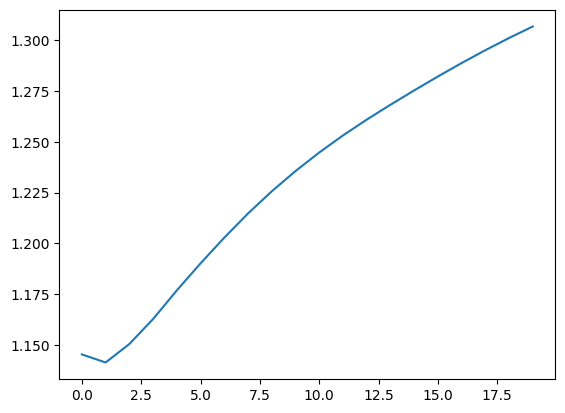

In [110]:

plt.plot(range(len(RMSES)), RMSES)
plt.show()


In [137]:
S.shape

(10, 10)

In [99]:
test_data_by_user_index[0]

[(6.0, 4.0),
 (101.0, 5.0),
 (223.0, 3.0),
 (543.0, 4.0),
 (1031.0, 5.0),
 (1214.0, 4.0),
 (1348.0, 4.0),
 (1580.0, 3.0),
 (1927.0, 5.0),
 (2028.0, 4.0),
 (2033.0, 5.0),
 (2858.0, 5.0),
 (2944.0, 5.0),
 (2949.0, 5.0),
 (3052.0, 5.0),
 (3147.0, 5.0),
 (3253.0, 5.0),
 (3617.0, 4.0)]

In [101]:
train_data_by_user_index[]

[(318.0, 3.0),
 (333.0, 4.0),
 (1704.0, 4.5),
 (3578.0, 4.0),
 (6874.0, 4.0),
 (8798.0, 3.5),
 (46970.0, 4.0),
 (58559.0, 4.5),
 (60756.0, 5.0),
 (68157.0, 4.5),
 (71535.0, 3.0),
 (74458.0, 4.0),
 (77455.0, 3.0),
 (79132.0, 4.0),
 (80489.0, 4.5),
 (80906.0, 5.0),
 (86345.0, 4.0),
 (91529.0, 3.5),
 (91658.0, 2.5),
 (99114.0, 3.5),
 (106782.0, 5.0),
 (112552.0, 4.0),
 (114060.0, 2.0),
 (115713.0, 3.5),
 (122882.0, 5.0)]

In [96]:
rated_by_user

[(1.0, 5.0),
 (6.0, 5.0),
 (16.0, 4.5),
 (32.0, 4.5),
 (47.0, 5.0),
 (50.0, 4.0),
 (95.0, 3.5),
 (110.0, 4.5),
 (111.0, 5.0),
 (112.0, 4.0),
 (153.0, 3.0),
 (159.0, 3.5),
 (194.0, 5.0),
 (215.0, 5.0),
 (231.0, 4.0),
 (260.0, 5.0),
 (293.0, 5.0),
 (296.0, 5.0),
 (303.0, 3.0),
 (319.0, 3.5),
 (328.0, 3.5),
 (332.0, 3.0),
 (344.0, 3.0),
 (367.0, 3.5),
 (407.0, 5.0),
 (412.0, 2.0),
 (441.0, 5.0),
 (457.0, 4.5),
 (464.0, 4.0),
 (471.0, 4.0),
 (480.0, 5.0),
 (519.0, 2.0),
 (527.0, 3.5),
 (541.0, 5.0),
 (589.0, 5.0),
 (592.0, 4.5),
 (593.0, 4.5),
 (608.0, 4.5),
 (714.0, 3.5),
 (735.0, 4.5),
 (741.0, 4.5),
 (750.0, 4.5),
 (778.0, 5.0),
 (780.0, 3.5),
 (784.0, 5.0),
 (785.0, 4.0),
 (849.0, 3.0),
 (858.0, 5.0),
 (903.0, 5.0),
 (904.0, 5.0),
 (923.0, 4.0),
 (924.0, 4.5),
 (1036.0, 5.0),
 (1047.0, 4.5),
 (1054.0, 2.0),
 (1080.0, 4.0),
 (1084.0, 4.0),
 (1089.0, 5.0),
 (1090.0, 4.0),
 (1097.0, 4.5),
 (1127.0, 4.0),
 (1128.0, 3.5),
 (1129.0, 4.0),
 (1136.0, 5.0),
 (1196.0, 5.0),
 (1197.0, 4.5),
 (119

In [57]:
map_movie_to_index

{1: 0,
 3: 1,
 6: 2,
 47: 3,
 50: 4,
 70: 5,
 101: 6,
 110: 7,
 151: 8,
 157: 9,
 163: 10,
 216: 11,
 223: 12,
 231: 13,
 235: 14,
 260: 15,
 296: 16,
 316: 17,
 333: 18,
 349: 19,
 356: 20,
 362: 21,
 367: 22,
 423: 23,
 441: 24,
 457: 25,
 480: 26,
 500: 27,
 527: 28,
 543: 29,
 552: 30,
 553: 31,
 590: 32,
 592: 33,
 593: 34,
 596: 35,
 608: 36,
 648: 37,
 661: 38,
 673: 39,
 733: 40,
 736: 41,
 780: 42,
 804: 43,
 919: 44,
 923: 45,
 940: 46,
 943: 47,
 954: 48,
 1009: 49,
 1023: 50,
 1024: 51,
 1025: 52,
 1029: 53,
 1030: 54,
 1031: 55,
 1032: 56,
 1042: 57,
 1049: 58,
 1060: 59,
 1073: 60,
 1080: 61,
 1089: 62,
 1090: 63,
 1092: 64,
 1097: 65,
 1127: 66,
 1136: 67,
 1196: 68,
 1197: 69,
 1198: 70,
 1206: 71,
 1208: 72,
 1210: 73,
 1213: 74,
 1214: 75,
 1219: 76,
 1220: 77,
 1222: 78,
 1224: 79,
 1226: 80,
 1240: 81,
 1256: 82,
 1258: 83,
 1265: 84,
 1270: 85,
 1275: 86,
 1278: 87,
 1282: 88,
 1291: 89,
 1298: 90,
 1348: 91,
 1377: 92,
 1396: 93,
 1408: 94,
 1445: 95,
 1473: 96,
 

In [51]:
l

0

In [59]:
data_by_user_index[i]

[(1.0, 4.0),
 (3.0, 4.0),
 (6.0, 4.0),
 (47.0, 5.0),
 (50.0, 5.0),
 (70.0, 3.0),
 (101.0, 5.0),
 (110.0, 4.0),
 (151.0, 5.0),
 (157.0, 5.0),
 (163.0, 5.0),
 (216.0, 5.0),
 (223.0, 3.0),
 (231.0, 5.0),
 (235.0, 4.0),
 (260.0, 5.0),
 (296.0, 3.0),
 (316.0, 3.0),
 (333.0, 5.0),
 (349.0, 4.0),
 (356.0, 4.0),
 (362.0, 5.0),
 (367.0, 4.0),
 (423.0, 3.0),
 (441.0, 4.0),
 (457.0, 5.0),
 (480.0, 4.0),
 (500.0, 3.0),
 (527.0, 5.0),
 (543.0, 4.0),
 (552.0, 4.0),
 (553.0, 5.0),
 (590.0, 4.0),
 (592.0, 4.0),
 (593.0, 4.0),
 (596.0, 5.0),
 (608.0, 5.0),
 (648.0, 3.0),
 (661.0, 5.0),
 (673.0, 3.0),
 (733.0, 4.0),
 (736.0, 3.0),
 (780.0, 3.0),
 (804.0, 4.0),
 (919.0, 5.0),
 (923.0, 5.0),
 (940.0, 5.0),
 (943.0, 4.0),
 (954.0, 5.0),
 (1009.0, 3.0),
 (1023.0, 5.0),
 (1024.0, 5.0),
 (1025.0, 5.0),
 (1029.0, 5.0),
 (1030.0, 3.0),
 (1031.0, 5.0),
 (1032.0, 5.0),
 (1042.0, 4.0),
 (1049.0, 5.0),
 (1060.0, 4.0),
 (1073.0, 5.0),
 (1080.0, 5.0),
 (1089.0, 5.0),
 (1090.0, 4.0),
 (1092.0, 5.0),
 (1097.0, 5.0),
 (

In [ ]:
import numpy as np
import time
import pandas as pd

def initialize_latent_matrices(n_users, n_movies, k):
    """
    Initialize latent factor matrices for users and movies.
    """
    U = np.random.rand(n_users, k)
    V = np.random.rand(n_movies, k)
    return U, V

def create_id_mappings(data):
    """
    Create mappings from user IDs and movie IDs to indices.
    """
    map_user_to_index = dict(zip(data['user_id'].unique(), range(len(data['user_id'].unique()))))
    map_movie_to_index = dict(zip(data['movie_id'].unique(), range(len(data['movie_id'].unique()))))
    return map_user_to_index, map_movie_to_index

def split_data(data, user_map, movie_map, train_ratio=0.9):
    """
    Split the dataset into training and testing sets by user and movie indices.
    """
    # Initialize training and testing data structures
    train_data_by_user = [[] for _ in range(len(user_map))]
    test_data_by_user = [[] for _ in range(len(user_map))]
    train_data_by_movie = [[] for _ in range(len(movie_map))]
    test_data_by_movie = [[] for _ in range(len(movie_map))]

    # Split the data
    for _, user_id, movie_id, rating, _ in data.itertuples():
        r = np.random.uniform()
        if r < train_ratio:
            train_data_by_user[user_map[user_id]].append((movie_id, rating))
            train_data_by_movie[movie_map[movie_id]].append((user_id, rating))
        else:
            test_data_by_user[user_map[user_id]].append((movie_id, rating))
            test_data_by_movie[movie_map[movie_id]].append((user_id, rating))

    return train_data_by_user, test_data_by_user, train_data_by_movie, test_data_by_movie

def measure_execution_time(func, *args, **kwargs):
    """
    Measure and print the execution time of a function.
    """
    start_time = time.time()
    result = func(*args, **kwargs)
    elapsed_time = time.time() - start_time
    print(f"Elapsed time: {elapsed_time:.2f} seconds")
    return result

# Example usage
if __name__ == "__main__":
    # Simulated dataset (replace with your actual data)
    data = pd.DataFrame({
        'user_id': np.random.randint(1, 101, 1000),
        'movie_id': np.random.randint(1, 51, 1000),
        'rating': np.random.uniform(1, 5, 1000),
        '_': [0] * 1000  # Dummy column for structure consistency
    })

    # Parameters
    n_users = len(data['user_id'].unique())
    n_movies = len(data['movie_id'].unique())
    k = 10  # Number of latent features

    # Initialize latent factor matrices
    U, V = initialize_latent_matrices(n_users, n_movies, k)

    # Create ID mappings
    user_map, movie_map = create_id_mappings(data)

    # Split data and measure execution time
    train_data_by_user, test_data_by_user, train_data_by_movie, test_data_by_movie = measure_execution_time(
        split_data, data, user_map, movie_map
    )

    print("Data splitting completed.")


In [22]:
import matplotlib.pyplot as plt
import numpy as np
import time

def initialize_matrices(n, m, k):
    U = np.random.normal(0, 1/(k**0.5), (n, k))
    V = np.random.normal(0, 1/(k**0.5), (m, k))
    user_biases = np.zeros(n)
    item_biases = np.zeros(m)
    return U, V, user_biases, item_biases

def update_user_biases(U, V, user_biases, item_biases, train_data_by_user_index, lambdaa, gamma, map_movie_to_index, k):
    n = len(user_biases)
    for i in range(n):
        bias = 0
        item_counter = 0
        rated_by_user = train_data_by_user_index[i].copy()
        u = U[i].copy()

        for l in range(len(rated_by_user)):
            v = V[map_movie_to_index[rated_by_user[l][0]]].copy()
            bias += lambdaa * (rated_by_user[l][1] - np.inner(u, v) - item_biases[map_movie_to_index[rated_by_user[l][0]]])
            item_counter += 1

        bias = bias / (lambdaa * item_counter + gamma)
        user_biases[i] = bias

def update_user_factors(U, V, user_biases, item_biases, train_data_by_user_index, lambdaa, tau, map_movie_to_index, k):
    n = len(U)
    for i in range(n):
        S = np.zeros((k, k))
        R = np.zeros((k, 1))
        I = tau * np.identity(k)
        rated_by_user = train_data_by_user_index[i]

        for l in range(len(rated_by_user)):
            v = V[map_movie_to_index[rated_by_user[l][0]]].copy()
            v = v.reshape(k, 1)
            S += lambdaa * np.matmul(v, v.T)
            R += lambdaa * v * (rated_by_user[l][1] - user_biases[i] - item_biases[map_movie_to_index[rated_by_user[l][0]]])

        U[i] = np.matmul(np.linalg.inv(S + I), R).flatten()

def update_item_biases(U, V, user_biases, item_biases, train_data_by_movie_index, lambdaa, gamma, map_user_to_index, k):
    m = len(item_biases)
    for i in range(m):
        bias = 0
        user_counter = 0
        v = V[i].copy()
        watched_by_user = train_data_by_movie_index[i].copy()

        for l in range(len(watched_by_user)):
            u = U[map_user_to_index[watched_by_user[l][0]]].copy()
            bias += lambdaa * (watched_by_user[l][1] - np.inner(u, v) - user_biases[map_user_to_index[watched_by_user[l][0]]])
            user_counter += 1

        bias = bias / (lambdaa * user_counter + gamma)
        item_biases[i] = bias

def update_item_factors(U, V, user_biases, item_biases, train_data_by_movie_index, lambdaa, tau, map_user_to_index, k):
    m = len(V)
    for i in range(m):
        S = np.zeros((k, k))
        R = np.zeros((k, 1))
        I = tau * np.identity(k)
        watched_by_user = train_data_by_movie_index[i]

        for l in range(len(watched_by_user)):
            u = U[map_user_to_index[watched_by_user[l][0]]].copy()
            u = u.reshape(k, 1)
            S += lambdaa * np.matmul(u, u.T)
            R += lambdaa * u * (watched_by_user[l][1] - user_biases[map_user_to_index[watched_by_user[l][0]]] - item_biases[i])

        V[i] = np.matmul(np.linalg.inv(S + I), R).flatten()

def compute_metrics(U, V, user_biases, item_biases, test_data_by_user_index, map_movie_to_index, gamma):
    RMSE = 0
    C = 0
    counter = 0
    for i in range(len(test_data_by_user_index)):
        for j in range(len(test_data_by_user_index[i])):
            rr = test_data_by_user_index[i][j][1]
            mm = map_movie_to_index[test_data_by_user_index[i][j][0]]
            pred = np.inner(U[i], V[mm]) + user_biases[i] + item_biases[mm]
            RMSE += (rr - pred)**2
            counter += 1
            C -= 0.5 * gamma * ((rr - pred)**2) + 0.5 * gamma * (item_biases[mm]**2 + user_biases[i]**2)
    return (RMSE / counter)**0.5, C



def train_biases_model(iterations, n, m, k, train_data_by_user_index, train_data_by_movie_index, test_data_by_user_index, map_movie_to_index, map_user_to_index, lambdaa, gamma, tau):
    U, V, user_biases, item_biases = initialize_matrices(n, m, k)
    costs = np.zeros(iterations)
    RMSES = np.zeros(iterations)

    tic = time.time()
    for r in range(iterations):
        print(f"Iteration {r + 1}/{iterations}")
        update_user_biases(U, V, user_biases, item_biases, train_data_by_user_index, lambdaa, gamma, map_movie_to_index, k)
        update_user_factors(U, V, user_biases, item_biases, train_data_by_user_index, lambdaa, tau, map_movie_to_index, k)
       # update_item_biases(U, V, user_biases, item_biases, train_data_by_movie_index, lambdaa, gamma, map_user_to_index, k)
       # update_item_factors(U, V, user_biases, item_biases, train_data_by_movie_index, lambdaa, tau, map_user_to_index, k)

        RMSE, C = compute_metrics(U, V, user_biases, item_biases, test_data_by_user_index, map_movie_to_index, gamma)
        costs[r] = C
        RMSES[r] = RMSE

        elapsed_time = time.time() - tic
        print(f"Elapsed time: {elapsed_time:.2f} seconds")
        print(f"Iteration {r + 1} RMSE: {RMSE:.4f}")

    print("Training complete!")
    plt.plot(range(len(RMSES)), RMSES)
    plt.xlabel("Iterations")
    plt.ylabel("RMSE")
    plt.title("RMSE Over Iterations")
    plt.show()
    return U, V, user_biases, item_biases, RMSES, costs

# Example usage (assuming data and mappings are provided):
# train_model(iterations, n, m, k, train_data_by_user_index, train_data_by_movie_index, test_data_by_user_index, map_movie_to_index, map_user_to_index, lambdaa, gamma, tau)




def train_full_model(iterations, n, m, k, train_data_by_user_index, train_data_by_movie_index, test_data_by_user_index, map_movie_to_index, map_user_to_index, lambdaa, gamma, tau):
    U, V, user_biases, item_biases = initialize_matrices(n, m, k)
    costs = np.zeros(iterations)
    RMSES = np.zeros(iterations)

    tic = time.time()
    for r in range(iterations):
        print(f"Iteration {r + 1}/{iterations}")
        update_user_biases(U, V, user_biases, item_biases, train_data_by_user_index, lambdaa, gamma, map_movie_to_index, k)
        update_user_factors(U, V, user_biases, item_biases, train_data_by_user_index, lambdaa, tau, map_movie_to_index, k)
        update_item_biases(U, V, user_biases, item_biases, train_data_by_movie_index, lambdaa, gamma, map_user_to_index, k)
        update_item_factors(U, V, user_biases, item_biases, train_data_by_movie_index, lambdaa, tau, map_user_to_index, k)

        RMSE, C = compute_metrics(U, V, user_biases, item_biases, test_data_by_user_index, map_movie_to_index, gamma)
        costs[r] = C
        RMSES[r] = RMSE

        elapsed_time = time.time() - tic
        print(f"Elapsed time: {elapsed_time:.2f} seconds")
        print(f"Iteration {r + 1} RMSE: {RMSE:.4f}")

    print("Training complete!")
    plt.plot(range(len(RMSES)), RMSES)
    plt.xlabel("Iterations")
    plt.ylabel("RMSE")
    plt.title("RMSE Over Iterations")
    plt.show()
    return U, V, user_biases, item_biases, RMSES, costs

# Example usage (assuming data and mappings are provided):
# train_model(iterations, n, m, k, train_data_by_user_index, train_data_by_movie_index, test_data_by_user_index, map_movie_to_index, map_user_to_index, lambdaa, gamma, tau)


In [ ]:
import pandas as pd
import numpy as np
import random

import time

#

n=len(df['userId'].unique())
m=len(df['movieId'].unique())

import numpy as np

k = 10
lambdaa = 2

U = np.random.rand(n, k)
V = np.random.rand(m, k)


tic = time.time()



map_user_to_index = dict(zip(df['userId'].unique(), range(len(df))))
map_movie_to_index = dict(zip(df['movieId'].unique(), range(len(df))))

train_data_by_user_index = [[] for _ in range(len(map_user_to_index))]
test_data_by_user_index=[[] for _ in range(len(map_user_to_index))]


train_data_by_movie_index = [[] for _ in range(len(map_movie_to_index))]
test_data_by_movie_index=[[] for _ in range(len(map_movie_to_index))]



for _, userId, movieId, rating, _ in df.itertuples():
    r = np.random.uniform(size=1)[0]
    if(r<0.90):
     train_data_by_user_index[map_user_to_index[userId]].append((movieId,rating))
     train_data_by_movie_index[map_movie_to_index[movieId]].append((userId,rating))
    else:
     test_data_by_user_index[map_user_to_index[userId]].append((movieId,rating))
     test_data_by_movie_index[map_movie_to_index[movieId]].append((userId,rating))



# for i in range(len(df)):
#    r = np.random.uniform(size=1)[0]
#    if(r<0.95):
#     train_data_by_user_index[map_user_to_index[df.iloc[i][0]]].append((df.iloc[i][1],df.iloc[i][2]))
#     #test_data_by_user_index[map_user_to_index[df.iloc[i][0]]].append([])

#     train_data_by_movie_index[map_movie_to_index[df.iloc[i][1]]].append((df.iloc[i][0],df.iloc[i][2]))
#     #test_data_by_movie_index[map_movie_to_index[df.iloc[i][1]]].append([])

#    else:
#     test_data_by_user_index[map_user_to_index[df.iloc[i][0]]].append((df.iloc[i][1],df.iloc[i][2]))
#     #train_data_by_user_index[map_user_to_index[df.iloc[i][0]]].append([])

#     test_data_by_movie_index[map_movie_to_index[df.iloc[i][1]]].append((df.iloc[i][0],df.iloc[i][2]))
#     #train_data_by_movie_index[map_movie_to_index[df.iloc[i][1]]].append([])

# #   data_by_user_index[map_user_to_index[df.iloc[i]['userId']]].append((df.iloc[i]['movieId'],df.iloc[i]['rating']))
# #   data_by_movie_index[map_movie_to_index[df.iloc[i]['movieId']]].append((df.iloc[i]['userId'],df.iloc[i]['rating']))




# for i in range(len(df)):
#   r = np.random.uniform(size=1)[0]
#   if(r<0.9):
#    data_by_user_train[map_user_to_index[df.iloc[i][0]]][map_movie_to_index[df.iloc[i][1]]]=df.iloc[i][2]
#    data_by_movie_train[map_movie_to_index[df.iloc[i][1]]][map_user_to_index[df.iloc[i][0]]]=df.iloc[i][2]

#   else:
#    data_by_user_test[map_user_to_index[df.iloc[i][0]]][map_movie_to_index[df.iloc[i][1]]]=df.iloc[i][2]
#    data_by_movie_test[map_movie_to_index[df.iloc[i][1]]][map_user_to_index[df.iloc[i][0]]]=df.iloc[i][2]

print("Donee")



# Code to measure

# Stop timer (toc)
toc = time.time()

# Calculate elapsed time
elapsed_time = toc - tic
print(f"Elapsed time: {elapsed_time:.2f} seconds")



In [30]:
mydata

NameError: name 'mydata' is not defined

In [204]:
import matplotlib.pyplot as plt
import numpy as np
import time

def train_model(iterations, n, m, k, train_data_by_user_index, train_data_by_movie_index, 
                test_data_by_user_index, map_movie_to_index, map_user_to_index, lambdaa, gamma, tau):
    # Initialize matrices
    U, V, user_biases, item_biases = initialize_matrices(n, m, k)
    train_costs = np.zeros(iterations)
    test_costs = np.zeros(iterations)
    train_RMSES = np.zeros(iterations)
    test_RMSES = np.zeros(iterations)

    tic = time.time()
    for r in range(iterations):
        print(f"Iteration {r + 1}/{iterations}")
        
        # Update biases and factors
        update_user_biases(U, V, user_biases, item_biases, train_data_by_user_index, lambdaa, gamma, map_movie_to_index)
        update_user_factors(U, V, user_biases, item_biases, train_data_by_user_index, lambdaa, tau, map_movie_to_index, k)
        update_item_biases(U, V, user_biases, item_biases, train_data_by_movie_index, lambdaa, gamma, map_user_to_index)
        update_item_factors(U, V, user_biases, item_biases, train_data_by_movie_index, lambdaa, tau, map_user_to_index, k)
        
        # Compute metrics for training and testing data
        train_RMSE, train_C = compute_metrics(U, V, user_biases, item_biases, train_data_by_user_index, map_movie_to_index, gamma)
        test_RMSE, test_C = compute_metrics(U, V, user_biases, item_biases, test_data_by_user_index, map_movie_to_index, gamma)

        train_costs[r] = train_C
        test_costs[r] = test_C
        train_RMSES[r] = train_RMSE
        test_RMSES[r] = test_RMSE

        elapsed_time = time.time() - tic
        print(f"Elapsed time: {elapsed_time:.2f} seconds")
        print(f"Iteration {r + 1} Train RMSE: {train_RMSE:.4f}, Test RMSE: {test_RMSE:.4f}")

    print("Training complete!")

    # Plot RMSE over iterations
    plt.figure(figsize=(8, 6))
    plt.plot(range(len(train_RMSES)), train_RMSES, label="Training RMSE", color="blue")
    plt.plot(range(len(test_RMSES)), test_RMSES, label="Testing RMSE", color="orange")
    plt.xlabel("Iterations")
    plt.ylabel("RMSE")
    plt.title("Training and Testing RMSE Over Iterations")
    plt.legend()
    plt.grid(True, linestyle="--", alpha=0.7)
    plt.savefig("full_rmse_plot_train_test.pdf", format="pdf")  # Save RMSE plot as PDF
    print("RMSE plot saved as 'rmse_plot.pdf'.")
    plt.close()  # Close the figure to avoid overlap

    # Plot negative loss over iterations
    plt.figure(figsize=(8, 6))
    plt.plot(range(len(train_costs)), -train_costs, label="Training Negative Loss", color="green")
    plt.plot(range(len(test_costs)), -test_costs, label="Testing Negative Loss", color="red")
    plt.xlabel("Iterations")
    plt.ylabel("Negative Loss")
    plt.title("Training and Testing Negative Loss Over Iterations")
    plt.legend()
    plt.grid(True, linestyle="--", alpha=0.7)
    plt.savefig("full_negative_loss_plot_train_test.pdf", format="pdf")  # Save Negative Loss plot as PDF
    print("Negative loss plot saved as 'negative_loss_plot.pdf'.")
    plt.close()  # Close the figure to avoid overlap

    return U, V, user_biases, item_biases, train_RMSES, test_RMSES, train_costs, test_costs

# Example usage (assuming data and mappings are provided):
# train_model(iterations, n, m, k, train_data_by_user_index, train_data_by_movie_index, test_data_by_user_index, map_movie_to_index, map_user_to_index, lambdaa, gamma, tau)


In [205]:
lambdaa=5
gamma=0.2
tau=0.1
k=10
U, V,user_biases , item_biases, RMSES,costs = train_model(iterations=10, n=n, m=m, k=k, train_data_by_user_index=train_data_by_user_index, train_data_by_movie_index=train_data_by_movie_index, test_data_by_user_index=test_data_by_user_index, map_movie_to_index=map_movie_to_index, map_user_to_index=map_user_to_index, lambdaa=lambdaa, gamma=gamma, tau=tau)


Iteration 1/10
Elapsed time: 82.65 seconds
Iteration 1 Train RMSE: 0.8226, Test RMSE: 0.9157
Iteration 2/10
Elapsed time: 177.49 seconds
Iteration 2 Train RMSE: 0.7792, Test RMSE: 0.8885
Iteration 3/10
Elapsed time: 259.93 seconds
Iteration 3 Train RMSE: 0.7515, Test RMSE: 0.8635
Iteration 4/10
Elapsed time: 338.59 seconds
Iteration 4 Train RMSE: 0.7339, Test RMSE: 0.8467
Iteration 5/10
Elapsed time: 421.27 seconds
Iteration 5 Train RMSE: 0.7232, Test RMSE: 0.8361
Iteration 6/10
Elapsed time: 505.83 seconds
Iteration 6 Train RMSE: 0.7165, Test RMSE: 0.8293
Iteration 7/10
Elapsed time: 588.81 seconds
Iteration 7 Train RMSE: 0.7121, Test RMSE: 0.8247
Iteration 8/10
Elapsed time: 669.89 seconds
Iteration 8 Train RMSE: 0.7090, Test RMSE: 0.8213
Iteration 9/10
Elapsed time: 749.70 seconds
Iteration 9 Train RMSE: 0.7067, Test RMSE: 0.8187
Iteration 10/10
Elapsed time: 833.98 seconds
Iteration 10 Train RMSE: 0.7051, Test RMSE: 0.8168
Training complete!
RMSE plot saved as 'rmse_plot.pdf'.
Nega

ValueError: too many values to unpack (expected 6)

In [145]:
#Working one ^_____^
k=20
iterations=100


lambdaa=5
gamma=0.2
tau=0.1


U_dummy = np.random.normal(0, 1/(k**0.5), (1, k))
U = np.concatenate([U, U_dummy], axis=0)
print(U.shape)

V = np.random.normal(0, 1/(k**0.5), (m, k))



lambdaa=5
gamma=0.2
tau=0.1

user_biases=np.append(user_biases,0)
print(user_biases.shape)

i=len(user_biases)-1

for r in range(iterations):
  tic=time.time()
  print(r)
  bias=0
  item_counter=0
  rated_by_user=[(244,5)]
  u=U[i].copy()

  for l in range(len(rated_by_user)):
      v=V[map_movie_to_index[rated_by_user[l][0]]].copy()
      bias=bias+lambdaa*(rated_by_user[l][1]-np.inner(u,v)-item_biases[map_movie_to_index[rated_by_user[l][0]]])
      item_counter=item_counter+1
  bias=bias/(lambdaa*item_counter+gamma)
  user_biases[i]=bias



  S = np.zeros(shape=(k, k))
  R = np.zeros(shape=(k, 1))
  I = tau*np.identity(k)
  for l in range(len(rated_by_user)):
      v=V[map_movie_to_index[rated_by_user[l][0]]].copy()
      v=np.asmatrix(v)
      v=v.reshape(k,1)
      S=S+lambdaa*np.matmul(v,np.transpose(v))
      R=R+lambdaa*v*(rated_by_user[l][1]-user_biases[i]-item_biases[map_movie_to_index[rated_by_user[l][0]]])
  U[i]=np.transpose(np.matmul(np.linalg.inv(S+I),R))


(200951, 20)
(200951,)
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


In [27]:
indx=200949
U[indx]

array([-0.55393345, -0.73180726, -0.92406958, -0.82979763, -0.5700831 ,
       -1.09885906,  1.12449193,  0.02839697,  0.54390105,  1.07214323,
        0.40456525,  0.14538119, -0.16882056,  0.05410232, -0.04617907,
        1.049546  , -0.08058801, -0.12040231, -0.37905509, -0.75532156])

In [146]:
myratings=[]
for i in range(m):
    r=np.dot(U[indx], V[i])+user_biases[indx]+item_biases[i]
    myratings.append(r)
    
sorted_indices = sorted(range(len(myratings)), key=lambda i: myratings[i])
    

In [152]:
def top_n_indices(lst, n=100):
    # Get indices of the top n elements
    return sorted(range(len(lst)), key=lambda i: lst[i], reverse=True)[:n]


In [153]:
l=top_n_indices(myratings)
names=[]

In [154]:
for s in range(len(l)):
    l[s]=reversed_map_movie_to_index[l[s]]

In [86]:

result = movies[movies["movieId"] == l]

ValueError: ('Lengths must match to compare', (87585,), (10,))

In [155]:
l

[183585,
 228663,
 222717,
 140004,
 172819,
 208100,
 182521,
 214910,
 215645,
 178945,
 218083,
 186359,
 228925,
 114652,
 165841,
 114353,
 186087,
 217270,
 231289,
 157484,
 131978,
 155802,
 291138,
 229259,
 185279,
 148923,
 218081,
 168588,
 196787,
 161600,
 290157,
 163563,
 291116,
 180081,
 197941,
 217965,
 245436,
 192021,
 176261,
 218073,
 163474,
 291308,
 182523,
 177303,
 193049,
 150637,
 241426,
 89203,
 200344,
 247296,
 124440,
 217931,
 273489,
 111592,
 265920,
 172457,
 291302,
 117606,
 66008,
 154341,
 250934,
 118995,
 281166,
 172705,
 271517,
 81795,
 144764,
 277894,
 226940,
 242044,
 275165,
 169628,
 178853,
 190941,
 185113,
 262053,
 215463,
 153054,
 222715,
 218077,
 150766,
 217747,
 283241,
 217180,
 85319,
 206467,
 180731,
 171733,
 159733,
 199936,
 264904,
 197821,
 270296,
 235059,
 108942,
 291112,
 224004,
 197281,
 70978,
 265946]

In [156]:
subset = movies[movies["movieId"].isin(l)]

In [157]:
subset

movieId                                              title  \
13026    66008                     Signos del zodiaco, Los (1964)   
13703    70978  Boyfriends and Girlfriends (a.k.a. My Girlfrie...   
15532    81795           Mein Leben - Marcel Reich-Ranicki (2009)   
16162    85319                   Mandabi (The Money Order) (1968)   
16954    89203                                  Magic Trip (2011)   
...        ...                                                ...   
87231   291112                             A Mother's Gift (1995)   
87233   291116                           God Save Our Farm (2008)   
87244   291138                                     Cutback (2010)   
87324   291302                           Desert Redemption (2015)   
87326   291308                             Lost Wilderness (2015)   

                   genres  
13026               Drama  
13703              Comedy  
15532               Drama  
16162               Drama  
16954         Documentary  
...                   ...  
87231       Drama|Western  
87233            Children  
87244               Drama  
87324               Drama  
87326  Adventure|Children  

[100 rows x 3 columns]

In [118]:
names=[]
for x in range(len(l)):
    names.append(movies[movies['movieId']==l[x]]['title'][0]+movies[movies['movieId']==l[x]]['genres'][0])

KeyError: 0

In [112]:
movies[movies['movieId']==1]['genres'][0]

'Adventure|Animation|Children|Comedy|Fantasy'

In [104]:
movies

movieId                               title  \
0            1                    Toy Story (1995)   
1            2                      Jumanji (1995)   
2            3             Grumpier Old Men (1995)   
3            4            Waiting to Exhale (1995)   
4            5  Father of the Bride Part II (1995)   
...        ...                                 ...   
87580   292731           The Monroy Affaire (2022)   
87581   292737          Shelter in Solitude (2023)   
87582   292753                         Orca (2023)   
87583   292755              The Angry Breed (1968)   
87584   292757           Race to the Summit (2023)   

                                            genres  
0      Adventure|Animation|Children|Comedy|Fantasy  
1                       Adventure|Children|Fantasy  
2                                   Comedy|Romance  
3                             Comedy|Drama|Romance  
4                                           Comedy  
...                                            ...  
87580                                        Drama  
87581                                 Comedy|Drama  
87582                                        Drama  
87583                                        Drama  
87584                 Action|Adventure|Documentary  

[87585 rows x 3 columns]

In [79]:
m

84432

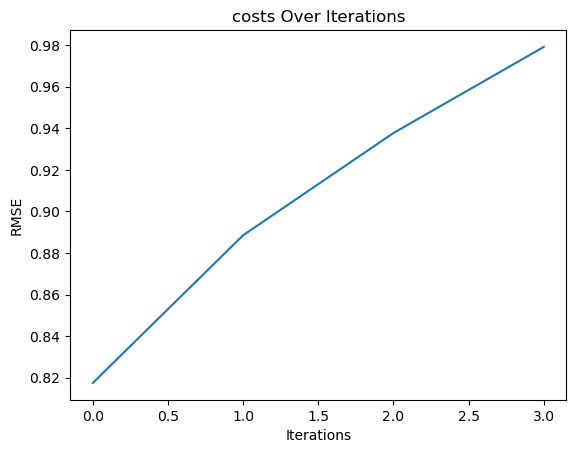

In [53]:
plt.plot(range(len(result)), result)
plt.xlabel("Iterations")
plt.ylabel("RMSE")
plt.title("costs Over Iterations")
plt.show()

2
Iteration 1/5
Elapsed time: 52.78 seconds
Iteration 1 RMSE: 0.8791
Iteration 2/5
Elapsed time: 105.50 seconds
Iteration 2 RMSE: 0.8570
Iteration 3/5
Elapsed time: 158.54 seconds
Iteration 3 RMSE: 0.8420
Iteration 4/5
Elapsed time: 212.26 seconds
Iteration 4 RMSE: 0.8308
Iteration 5/5
Elapsed time: 265.78 seconds
Iteration 5 RMSE: 0.8246
Training complete!


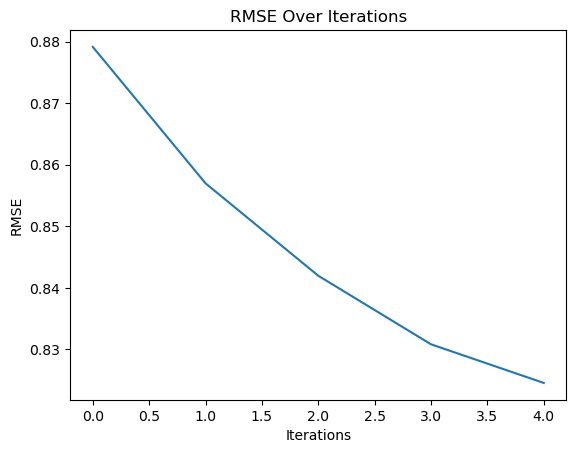

7
Iteration 1/5
Elapsed time: 67.39 seconds
Iteration 1 RMSE: 0.8987
Iteration 2/5
Elapsed time: 134.21 seconds
Iteration 2 RMSE: 0.8698
Iteration 3/5
Elapsed time: 199.00 seconds
Iteration 3 RMSE: 0.8438
Iteration 4/5
Elapsed time: 266.52 seconds
Iteration 4 RMSE: 0.8284
Iteration 5/5
Elapsed time: 331.48 seconds
Iteration 5 RMSE: 0.8184
Training complete!


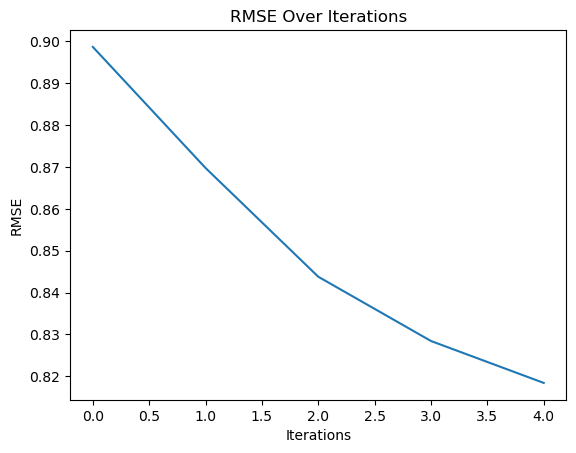

12
Iteration 1/5
Elapsed time: 80.37 seconds
Iteration 1 RMSE: 0.9318
Iteration 2/5


KeyboardInterrupt: 

In [44]:
lambdaa=5
gamma=0.2
tau=0.1

U, V, user_biases, item_biases, RMSES, costs = best_k_train_model(iterations=5, n=n, m=m, train_data_by_user_index=train_data_by_user_index, train_data_by_movie_index=train_data_by_movie_index, test_data_by_user_index=test_data_by_user_index, map_movie_to_index=map_movie_to_index, map_user_to_index=map_user_to_index, lambdaa=lambdaa, gamma=gamma, tau=tau)

In [24]:
import matplotlib.pyplot as plt
import numpy as np
import time
import concurrent.futures

def initialize_matrices(n, m, k):
    U = np.random.normal(0, 1/(k**0.5), (n, k))
    V = np.random.normal(0, 1/(k**0.5), (m, k))
    user_biases = np.zeros(n)
    item_biases = np.zeros(m)
    return U, V, user_biases, item_biases

def update_user_biases_parallel(i, U, V, user_biases, item_biases, train_data_by_user_index, lambdaa, gamma, map_movie_to_index, k):
    bias = 0
    item_counter = 0
    rated_by_user = train_data_by_user_index[i].copy()
    u = U[i].copy()

    for l in range(len(rated_by_user)):
        v = V[map_movie_to_index[rated_by_user[l][0]]].copy()
        bias += lambdaa * (rated_by_user[l][1] - np.inner(u, v) - item_biases[map_movie_to_index[rated_by_user[l][0]]])
        item_counter += 1

    bias = bias / (lambdaa * item_counter + gamma)
    user_biases[i] = bias

def update_user_factors_parallel(i, U, V, user_biases, item_biases, train_data_by_user_index, lambdaa, tau, map_movie_to_index, k):
    S = np.zeros((k, k))
    R = np.zeros((k, 1))
    I = tau * np.identity(k)
    rated_by_user = train_data_by_user_index[i]

    for l in range(len(rated_by_user)):
        v = V[map_movie_to_index[rated_by_user[l][0]]].copy()
        v = v.reshape(k, 1)
        S += lambdaa * np.matmul(v, v.T)
        R += lambdaa * v * (rated_by_user[l][1] - user_biases[i] - item_biases[map_movie_to_index[rated_by_user[l][0]]])

    U[i] = np.matmul(np.linalg.inv(S + I), R).flatten()

def update_item_biases_parallel(i, U, V, user_biases, item_biases, train_data_by_movie_index, lambdaa, gamma, map_user_to_index, k):
    bias = 0
    user_counter = 0
    v = V[i].copy()
    watched_by_user = train_data_by_movie_index[i].copy()

    for l in range(len(watched_by_user)):
        u = U[map_user_to_index[watched_by_user[l][0]]].copy()
        bias += lambdaa * (watched_by_user[l][1] - np.inner(u, v) - user_biases[map_user_to_index[watched_by_user[l][0]]])
        user_counter += 1

    bias = bias / (lambdaa * user_counter + gamma)
    item_biases[i] = bias

def update_item_factors_parallel(i, U, V, user_biases, item_biases, train_data_by_movie_index, lambdaa, tau, map_user_to_index, k):
    S = np.zeros((k, k))
    R = np.zeros((k, 1))
    I = tau * np.identity(k)
    watched_by_user = train_data_by_movie_index[i]

    for l in range(len(watched_by_user)):
        u = U[map_user_to_index[watched_by_user[l][0]]].copy()
        u = u.reshape(k, 1)
        S += lambdaa * np.matmul(u, u.T)
        R += lambdaa * u * (watched_by_user[l][1] - user_biases[map_user_to_index[watched_by_user[l][0]]] - item_biases[i])

    V[i] = np.matmul(np.linalg.inv(S + I), R).flatten()

def compute_metrics(U, V, user_biases, item_biases, test_data_by_user_index, map_movie_to_index, gamma):
    RMSE = 0
    C = 0
    counter = 0
    for i in range(len(test_data_by_user_index)):
        for j in range(len(test_data_by_user_index[i])):
            rr = test_data_by_user_index[i][j][1]
            mm = map_movie_to_index[test_data_by_user_index[i][j][0]]
            pred = np.inner(U[i], V[mm]) + user_biases[i] + item_biases[mm]
            RMSE += (rr - pred)**2
            counter += 1
            C -= 0.5 * gamma * ((rr - pred)**2) + 0.5 * gamma * (item_biases[mm]**2 + user_biases[i]**2)
    return (RMSE / counter)**0.5, C

def train_model(iterations, n, m, k, train_data_by_user_index, train_data_by_movie_index, test_data_by_user_index, map_movie_to_index, map_user_to_index, lambdaa, gamma, tau):
    U, V, user_biases, item_biases = initialize_matrices(n, m, k)
    costs = np.zeros(iterations)
    RMSES = np.zeros(iterations)

    tic = time.time()
    for r in range(iterations):
        print(f"Iteration {r + 1}/{iterations}")
        
        # Parallelize the update steps
        with concurrent.futures.ThreadPoolExecutor() as executor:
            futures = []
            
            # Update user biases in parallel
            for i in range(n):
                futures.append(executor.submit(update_user_biases_parallel, i, U, V, user_biases, item_biases, train_data_by_user_index, lambdaa, gamma, map_movie_to_index, k))
                
            # Update user factors in parallel
            for i in range(n):
                futures.append(executor.submit(update_user_factors_parallel, i, U, V, user_biases, item_biases, train_data_by_user_index, lambdaa, tau, map_movie_to_index, k))
            
            # Update item biases in parallel
            for i in range(m):
                futures.append(executor.submit(update_item_biases_parallel, i, U, V, user_biases, item_biases, train_data_by_movie_index, lambdaa, gamma, map_user_to_index, k))
            
            # Update item factors in parallel
            for i in range(m):
                futures.append(executor.submit(update_item_factors_parallel, i, U, V, user_biases, item_biases, train_data_by_movie_index, lambdaa, tau, map_user_to_index, k))
                
            # Wait for all futures to complete
            concurrent.futures.wait(futures)

        RMSE, C = compute_metrics(U, V, user_biases, item_biases, test_data_by_user_index, map_movie_to_index, gamma)
        costs[r] = C
        RMSES[r] = RMSE

        elapsed_time = time.time() - tic
        print(f"Elapsed time: {elapsed_time:.2f} seconds")
        print(f"Iteration {r + 1} RMSE: {RMSE:.4f}")

    print("Training complete!")
    plt.plot(range(len(RMSES)), RMSES)
    plt.xlabel("Iterations")
    plt.ylabel("RMSE")
    plt.title("RMSE Over Iterations")
    plt.show()
    return U, V, user_biases, item_biases, RMSES, costs

# Example usage (assuming data and mappings are provided):
# train_model(iterations, n, m, k, train_data_by_user_index, train_data_by_movie_index, test_data_by_user_index, map_movie_to_index, map_user_to_index, lambdaa, gamma, tau)


In [80]:
def read_dat_data(path):
    

 mydata = pd.read_csv(path, delimiter="::", header=0)
 mydata = mydata.drop(mydata.index[-1])
 mydata.columns=['user_id', 'movie_id','rating','timestamp']
 
 return(mydata)




def read_csv_data(path):
    

  mydata = pd.read_csv(path, delimiter=",")
  mydata.columns=['user_id', 'movie_id','genres']
 
  return(mydata)




movies=read_csv_data("/home/ahmedaa/Desktop/ml-32m/movies.csv")  


In [81]:
movies

user_id                            movie_id  \
0            1                    Toy Story (1995)   
1            2                      Jumanji (1995)   
2            3             Grumpier Old Men (1995)   
3            4            Waiting to Exhale (1995)   
4            5  Father of the Bride Part II (1995)   
...        ...                                 ...   
87580   292731           The Monroy Affaire (2022)   
87581   292737          Shelter in Solitude (2023)   
87582   292753                         Orca (2023)   
87583   292755              The Angry Breed (1968)   
87584   292757           Race to the Summit (2023)   

                                            genres  
0      Adventure|Animation|Children|Comedy|Fantasy  
1                       Adventure|Children|Fantasy  
2                                   Comedy|Romance  
3                             Comedy|Drama|Romance  
4                                           Comedy  
...                                            ...  
87580                                        Drama  
87581                                 Comedy|Drama  
87582                                        Drama  
87583                                        Drama  
87584                 Action|Adventure|Documentary  

[87585 rows x 3 columns]

In [82]:


def read_movies_csv_data(path):
    

  mydata = pd.read_csv(path, delimiter=",")
  mydata.columns=['movieId', 'title','genres']
 
  return(mydata)




movies=read_movies_csv_data("/home/ahmedaa/Desktop/ml-32m/movies.csv")  


In [83]:
movies

movieId                               title  \
0            1                    Toy Story (1995)   
1            2                      Jumanji (1995)   
2            3             Grumpier Old Men (1995)   
3            4            Waiting to Exhale (1995)   
4            5  Father of the Bride Part II (1995)   
...        ...                                 ...   
87580   292731           The Monroy Affaire (2022)   
87581   292737          Shelter in Solitude (2023)   
87582   292753                         Orca (2023)   
87583   292755              The Angry Breed (1968)   
87584   292757           Race to the Summit (2023)   

                                            genres  
0      Adventure|Animation|Children|Comedy|Fantasy  
1                       Adventure|Children|Fantasy  
2                                   Comedy|Romance  
3                             Comedy|Drama|Romance  
4                                           Comedy  
...                                            ...  
87580                                        Drama  
87581                                 Comedy|Drama  
87582                                        Drama  
87583                                        Drama  
87584                 Action|Adventure|Documentary  

[87585 rows x 3 columns]

In [6]:
movies=pd.read_csv("/home/ahmedaa/Desktop/ml-10M100K/movies.dat",delimiter="::",)  

/tmp/ipykernel_807307/1284848615.py:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  movies=pd.read_csv("/home/ahmedaa/Desktop/ml-10M100K/movies.dat",delimiter="::",)


In [35]:
movies

movieId                               title  \
0            1                    Toy Story (1995)   
1            2                      Jumanji (1995)   
2            3             Grumpier Old Men (1995)   
3            4            Waiting to Exhale (1995)   
4            5  Father of the Bride Part II (1995)   
...        ...                                 ...   
10676    65088              Bedtime Stories (2008)   
10677    65091          Manhattan Melodrama (1934)   
10678    65126                        Choke (2008)   
10679    65130           Revolutionary Road (2008)   
10680    65133      Blackadder Back & Forth (1999)   

                                            genres  
0      Adventure|Animation|Children|Comedy|Fantasy  
1                       Adventure|Children|Fantasy  
2                                   Comedy|Romance  
3                             Comedy|Drama|Romance  
4                                           Comedy  
...                                            ...  
10676                    Adventure|Children|Comedy  
10677                          Crime|Drama|Romance  
10678                                 Comedy|Drama  
10679                                Drama|Romance  
10680                                       Comedy  

[10681 rows x 3 columns]

In [9]:
import pandas as pd
import numpy as np
import time



# Create the user-item matrix (rows: users, columns: movies)
R_df = ratings.pivot(index='userId', columns='movieId', values='rating').fillna(0)
R = R_df.values  # Convert to numpy matrix
n_users, n_movies = R.shape

# Initialize matrices U and V (latent factor matrices)
k = 50  # Number of latent factors
U = np.random.normal(0, 0.1, (n_users, k))  # User latent matrix
V = np.random.normal(0, 0.1, (n_movies, k))  # Item latent matrix

# Hyperparameters
lambda_reg = 0.1  # Regularization term
n_iterations = 50  # Number of ALS iterations

# Function to update user matrix U
def update_U(U, V, R, lambda_reg):
    for i in range(n_users):
        # Extract the ratings for the i-th user
        ratings_i = R[i, :]
        # Find the indices of non-zero ratings (movies rated by the user)
        rated_items = np.where(ratings_i > 0)[0]
        
        # Calculate the regularized least squares solution for the user factors
        V_rated = V[rated_items, :]  # Corresponding item factors
        R_rated = ratings_i[rated_items]  # Ratings for rated items
        
        # Solve for the user factors using normal equations
        A = np.dot(V_rated.T, V_rated) + lambda_reg * np.eye(k)
        b = np.dot(V_rated.T, R_rated)
        U[i, :] = np.linalg.solve(A, b)

# Function to update item matrix V
def update_V(U, V, R, lambda_reg):
    for j in range(n_movies):
        # Extract the ratings for the j-th movie
        ratings_j = R[:, j]
        # Find the indices of non-zero ratings (users who rated the movie)
        rated_users = np.where(ratings_j > 0)[0]
        
        # Calculate the regularized least squares solution for the item factors
        U_rated = U[rated_users, :]  # Corresponding user factors
        R_rated = ratings_j[rated_users]  # Ratings by users
        
        # Solve for the item factors using normal equations
        A = np.dot(U_rated/home/ahmedaa/Desktop/ml-10M100K/.T, U_rated) + lambda_reg * np.eye(k)
        b = np.dot(U_rated.T, R_rated)
        V[j, :] = np.linalg.solve(A, b)

# Train the ALS model
for iteration in range(n_iterations):
    print(f"Iteration {iteration + 1}/{n_iterations}...")
    
    # Update user and item matrices
    update_U(U, V, R, lambda_reg)
    update_V(U, V, R, lambda_reg)
    
    # Optionally compute the error for monitoring the training process
    if (iteration + 1) % 10 == 0:
        # Compute the RMSE
        predicted_R = np.dot(U, V.T)
        error = R - predicted_R
        mse = np.mean(error[error != 0]**2)  # Mean squared error for non-zero ratings
        rmse = np.sqrt(mse)
        print(f"Iteration {iteration + 1} RMSE: {rmse:.4f}")

# After training, make predictions for a given user
def recommend_for_user(user_id, num_recommendations=5):
    user_ratings = R_df.iloc[user_id-1].values  # User ratings (1-based index)
    user_predicted_ratings = np.dot(U[user_id-1], V.T)  # Predicted ratings for all items
    recommendations = [(movie_id, user_predicted_ratings[movie_id-1]) 
                       for movie_id, rating in enumerate(user_ratings) if rating == 0]
    recommendations = sorted(recommendations, key=lambda x: x[1], reverse=True)  # Sort by predicted rating
    recommended_movie_ids = [movie_id for movie_id, _ in recommendations[:num_recommendations]]
    
    # Retrieve movie titles
    recommended_movie_titles = movies[movies['movieId'].isin(recommended_movie_ids)]['title']
    return recommended_movie_titles

# Example: Get top 5 recommendations for user 1
print("Top 5 recommendations for User 1:")
recommended_movies = recommend_for_user(1, 5)
print(recommended_movies)


SyntaxError: invalid decimal literal (405810879.py, line 51)

In [5]:
#Data inport
import pandas as pd
import numpy as np
import random
from collections import Counter
R_df = ratings.pivot(index='user_id', columns='movie_id', values='rating').fillna(0)
R = R_df.values  # Convert to numpy matrix
n_users, n_movies = R.shape

In [21]:
n_movies

10677

In [22]:
R

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [5., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [1]:
import numpy as np
from scipy.sparse import csr_matrix


lambdaa=5
gamma=0.2
tau=0.1

def als_large_scale(ratings, n_factors=10, n_iterations=10, regularization=5, tau=0.1, batch_size=1000):
    """
    Optimized ALS implementation for large-scale datasets with memory management, including user and item biases.

    Args:
        ratings (scipy.sparse.csr_matrix): Sparse user-item ratings matrix.
        n_factors (int): Number of latent factors.
        n_iterations (int): Number of ALS iterations.
        regularization (float): Regularization parameter for latent factors.
        tau (float): Regularization parameter for biases.
        batch_size (int): Batch size for updates to manage memory.

    Returns:
        P (numpy.ndarray): User latent factors matrix.
        Q (numpy.ndarray): Item latent factors matrix.
        user_biases (numpy.ndarray): User bias vector.
        item_biases (numpy.ndarray): Item bias vector.
    """
    n_users, n_items = ratings.shape
    
    print(f"Starting ALS with {n_users} users and {n_items} items")
    
    # Initialize user (P) and item (Q) latent factor matrices randomly
    P = np.random.rand(n_users, n_factors)
    Q = np.random.rand(n_items, n_factors)

    # Initialize user and item biases
    user_biases = np.zeros(n_users)
    item_biases = np.zeros(n_items)

    global_mean = ratings.data.mean()

    for iteration in range(n_iterations):
        print(f"Iteration {iteration + 1}/{n_iterations}")

        # Update user latent factors and biases in batches
        for u_start in range(0, n_users, batch_size):
            u_end = min(u_start + batch_size, n_users)
            for u in range(u_start, u_end):
                start_idx, end_idx = ratings.indptr[u], ratings.indptr[u + 1]
                item_indices = ratings.indices[start_idx:end_idx]
                r_u = ratings.data[start_idx:end_idx]

                if len(item_indices) > 0:
                    Q_rated = Q[item_indices, :]
                    r_u_adjusted = r_u - global_mean - item_biases[item_indices]

                    A = Q_rated.T @ Q_rated + regularization * np.eye(n_factors)
                    b = Q_rated.T @ r_u_adjusted
                    P[u, :] = np.linalg.solve(A, b)

                    user_biases[u] = (r_u_adjusted - P[u, :] @ Q_rated.T).mean() / (1 + tau)

        # Update item latent factors and biases in batches
        for i_start in range(0, n_items, batch_size):
            i_end = min(i_start + batch_size, n_items)
            for i in range(i_start, i_end):
                start_idx, end_idx = ratings.indptr[i], ratings.indptr[i + 1]
                user_indices = ratings.indices[start_idx:end_idx]
                r_i = ratings.data[start_idx:end_idx]

                if len(user_indices) > 0:
                    P_rated = P[user_indices, :]
                    r_i_adjusted = r_i - global_mean - user_biases[user_indices]

                    A = P_rated.T @ P_rated + regularization * np.eye(n_factors)
                    b = P_rated.T @ r_i_adjusted
                    Q[i, :] = np.linalg.solve(A, b)

                    item_biases[i] = (r_i_adjusted - Q[i, :] @ P_rated.T).mean() / (1 + tau)

        # Compute RMSE over non-zero entries
        error = 0
        count = 0
        for u in range(n_users):
            start_idx, end_idx = ratings.indptr[u], ratings.indptr[u + 1]
            item_indices = ratings.indices[start_idx:end_idx]
            r_u = ratings.data[start_idx:end_idx]
            pred = global_mean + user_biases[u] + item_biases[item_indices] + P[u, :] @ Q[item_indices, :].T
            error += ((r_u - pred) ** 2).sum()
            count += len(r_u)
        error = np.sqrt(error / count)
        print(f"Iteration {iteration + 1} completed, RMSE: {error:.4f}")

    return P, Q, user_biases, item_biases

# Example usage

# Example usage
if __name__ == "__main__":
    # Example user-item ratings matrix (0 represents no rating)
    ratings_matrix =R

    # Train ALS recommender
    user_factors, item_factors = als_recommender(ratings_matrix, n_factors=3, n_iterations=10, regularization=0.1)

    # Predicted ratings
    predicted_ratings = user_factors @ item_factors.T
    print("Predicted Ratings:")
    print(predicted_ratings)


NameError: name 'R' is not defined

In [21]:
import numpy as np
from scipy.sparse import csr_matrix

def als_large_scale(ratings, n_factors=10, n_iterations=10, regularization=5, tau=0.2, gamma=0.1, batch_size=32000000):
    """
    Optimized ALS implementation for large-scale datasets with memory management, including user and item biases.

    Args:
        ratings (scipy.sparse.csr_matrix): Sparse user-item ratings matrix.
        n_factors (int): Number of latent factors.
        n_iterations (int): Number of ALS iterations.
        regularization (float): Regularization parameter for latent factors.
        tau (float): Regularization parameter for user and item latent factors.
        gamma (float): Regularization parameter for user and item biases.
        batch_size (int): Batch size for updates to manage memory.

    Returns:
        P (numpy.ndarray): User latent factors matrix.
        Q (numpy.ndarray): Item latent factors matrix.
        user_biases (numpy.ndarray): User bias vector.
        item_biases (numpy.ndarray): Item bias vector.
    """
    n_users, n_items = ratings.shape
    
    print(f"Starting ALS with {n_users} users and {n_items} items")
    
    # Initialize user (P) and item (Q) latent factor matrices randomly
    P = np.random.rand(n_users, n_factors)
    Q = np.random.rand(n_items, n_factors)

    # Initialize user and item biases
    user_biases = np.zeros(n_users)
    item_biases = np.zeros(n_items)

    global_mean = ratings.data.mean()

    for iteration in range(n_iterations):
        print(f"Iteration {iteration + 1}/{n_iterations}")

        # Update user latent factors and biases in batches
        for u_start in range(0, n_users, batch_size):
            u_end = min(u_start + batch_size, n_users)
            for u in range(u_start, u_end):
                start_idx, end_idx = ratings.indptr[u], ratings.indptr[u + 1]
                item_indices = ratings.indices[start_idx:end_idx]
                r_u = ratings.data[start_idx:end_idx]

                if len(item_indices) > 0:
                    Q_rated = Q[item_indices, :]
                    r_u_adjusted = r_u - global_mean - item_biases[item_indices]

                    A = Q_rated.T @ Q_rated + regularization * np.eye(n_factors)
                    b = Q_rated.T @ r_u_adjusted
                    P[u, :] = np.linalg.solve(A, b)

                    user_biases[u] = (r_u_adjusted - P[u, :] @ Q_rated.T).mean() / (1 + gamma)

        # Update item latent factors and biases in batches
        for i_start in range(0, n_items, batch_size):
            i_end = min(i_start + batch_size, n_items)
            for i in range(i_start, i_end):
                start_idx, end_idx = ratings.indptr[i], ratings.indptr[i + 1]
                user_indices = ratings.indices[start_idx:end_idx]
                r_i = ratings.data[start_idx:end_idx]

                if len(user_indices) > 0:
                    P_rated = P[user_indices, :]
                    r_i_adjusted = r_i - global_mean - user_biases[user_indices]

                    A = P_rated.T @ P_rated + regularization * np.eye(n_factors)
                    b = P_rated.T @ r_i_adjusted
                    Q[i, :] = np.linalg.solve(A, b)

                    item_biases[i] = (r_i_adjusted - Q[i, :] @ P_rated.T).mean() / (1 + gamma)

        # Compute RMSE over non-zero entries
        error = 0
        count = 0
        for u in range(n_users):
            start_idx, end_idx = ratings.indptr[u], ratings.indptr[u + 1]
            item_indices = ratings.indices[start_idx:end_idx]
            r_u = ratings.data[start_idx:end_idx]
            pred = global_mean + user_biases[u] + item_biases[item_indices] + P[u, :] @ Q[item_indices, :].T
            error += ((r_u - pred) ** 2).sum()
            count += len(r_u)
        error = np.sqrt(error / count)
        print(f"Iteration {iteration + 1} completed, RMSE: {error:.4f}")

    return P, Q, user_biases, item_biases

if __name__ == "__main__":
    from scipy.sparse import coo_matrix
    
    print("Generating synthetic dataset...")
    
    # Simulate a large sparse ratings matrix (MovieLens 32M format)
    # Replace with real data loading
    #data = np.random.randint(1, 6, size=32000000)
    #rows = np.random.randint(0, 138493, size=32000000)  # 138k users
    #cols = np.random.randint(0, 26744, size=32000000)   # 26k items

    #ratings_matrix = coo_matrix((data, (rows, cols)), shape=(138493, 26744)).tocsr()
    
    R=coo_matrix(R).tocsr()
    
    print("Dataset generated. Starting ALS training...")
    
    # Train ALS recommender
   # user_factors, item_factors = als_large_scale(R, n_factors=20, n_iterations=10, regularization=0.1)
     user_factors, item_factors, user_biases, item_biases = als_large_scale(ratings, n_factors=10, n_iterations=10, regularization=5, tau=0.2, gamma=0.1, batch_size=32000000)

    print("ALS training complete.")


IndentationError: unexpected indent (3661794506.py, line 110)

In [25]:
import numpy as np
from scipy.sparse import csr_matrix

def als_large_scale(ratings, n_factors=10, n_iterations=10, regularization=0.1, tau=0.1, gamma=0.1, batch_size=32000000):
    """
    Optimized ALS implementation for large-scale datasets with memory management, including user and item biases.

    Args:
        ratings (scipy.sparse.csr_matrix): Sparse user-item ratings matrix.
        n_factors (int): Number of latent factors.
        n_iterations (int): Number of ALS iterations.
        regularization (float): Regularization parameter for latent factors.
        tau (float): Regularization parameter for user and item latent factors.
        gamma (float): Regularization parameter for user and item biases.
        batch_size (int): Batch size for updates to manage memory.

    Returns:
        P (numpy.ndarray): User latent factors matrix.
        Q (numpy.ndarray): Item latent factors matrix.
        user_biases (numpy.ndarray): User bias vector.
        item_biases (numpy.ndarray): Item bias vector.
    """
    n_users, n_items = ratings.shape
    
    print(f"Starting ALS with {n_users} users and {n_items} items")
    
    # Initialize user (P) and item (Q) latent factor matrices randomly
    P = np.random.rand(n_users, n_factors)
    Q = np.random.rand(n_items, n_factors)

    # Initialize user and item biases
    user_biases = np.zeros(n_users)
    item_biases = np.zeros(n_items)

    global_mean = ratings.data.mean()

    for iteration in range(n_iterations):
        print(f"Iteration {iteration + 1}/{n_iterations}")

        # Update user latent factors and biases in batches
        for u_start in range(0, n_users, batch_size):
            u_end = min(u_start + batch_size, n_users)
            for u in range(u_start, u_end):
                start_idx, end_idx = ratings.indptr[u], ratings.indptr[u + 1]
                item_indices = ratings.indices[start_idx:end_idx]
                r_u = ratings.data[start_idx:end_idx]

                if len(item_indices) > 0:
                    Q_rated = Q[item_indices, :]
                    r_u_adjusted = r_u - global_mean - item_biases[item_indices]

                    A = Q_rated.T @ Q_rated + regularization * np.eye(n_factors)
                    b = Q_rated.T @ r_u_adjusted
                    P[u, :] = np.linalg.solve(A, b)

                    user_biases[u] = (r_u_adjusted - P[u, :] @ Q_rated.T).mean() / (1 + gamma)

        # Update item latent factors and biases in batches
        for i_start in range(0, n_items, batch_size):
            i_end = min(i_start + batch_size, n_items)
            for i in range(i_start, i_end):
                start_idx, end_idx = ratings.indptr[i], ratings.indptr[i + 1]
                user_indices = ratings.indices[start_idx:end_idx]
                r_i = ratings.data[start_idx:end_idx]

                if len(user_indices) > 0:
                    P_rated = P[user_indices, :]
                    r_i_adjusted = r_i - global_mean - user_biases[user_indices]

                    A = P_rated.T @ P_rated + regularization * np.eye(n_factors)
                    b = P_rated.T @ r_i_adjusted
                    Q[i, :] = np.linalg.solve(A, b)

                    item_biases[i] = (r_i_adjusted - Q[i, :] @ P_rated.T).mean() / (1 + gamma)

        # Compute RMSE over non-zero entries
        error = 0
        count = 0
        for u in range(n_users):
            start_idx, end_idx = ratings.indptr[u], ratings.indptr[u + 1]
            item_indices = ratings.indices[start_idx:end_idx]
            r_u = ratings.data[start_idx:end_idx]
            pred = global_mean + user_biases[u] + item_biases[item_indices] + P[u, :] @ Q[item_indices, :].T
            error += ((r_u - pred) ** 2).sum()
            count += len(r_u)
        error = np.sqrt(error / count)
        print(f"Iteration {iteration + 1} completed, RMSE: {error:.4f}")

    return P, Q, user_biases, item_biases

# Example usage
if __name__ == "__main__":
    from scipy.sparse import coo_matrix
    
    print("Generating synthetic dataset...")
    
    R=coo_matrix(R).tocsr()
    
    print("Dataset generated. Starting ALS training...")
    
    # Train ALS recommender
    user_factors, item_factors, user_biases, item_biases = als_large_scale(R, n_factors=20, n_iterations=10, regularization=5, tau=0.1, gamma=0.2)

    print("ALS training complete.")


Generating synthetic dataset...
Dataset generated. Starting ALS training...
Starting ALS with 69878 users and 10677 items
Iteration 1/10
Iteration 1 completed, RMSE: 1.1173
Iteration 2/10
Iteration 2 completed, RMSE: 1.1477
Iteration 3/10
Iteration 3 completed, RMSE: 1.1434
Iteration 4/10
Iteration 4 completed, RMSE: 1.1476
Iteration 5/10
Iteration 5 completed, RMSE: 1.1463
Iteration 6/10
Iteration 6 completed, RMSE: 1.1527
Iteration 7/10
Iteration 7 completed, RMSE: 1.1485
Iteration 8/10
Iteration 8 completed, RMSE: 1.1502
Iteration 9/10
Iteration 9 completed, RMSE: 1.1506
Iteration 10/10
Iteration 10 completed, RMSE: 1.1489
ALS training complete.


In [230]:
#Vectorized

import matplotlib.pyplot as plt
import numpy as np
import time

def initialize_matrices(n, m, k):
    U = np.random.normal(0, 1/(k**0.5), (n, k))
    V = np.random.normal(0, 1/(k**0.5), (m, k))
    user_biases = np.zeros(n)
    item_biases = np.zeros(m)
    return U, V, user_biases, item_biases

def update_user_biases(U, V, user_biases, item_biases, train_data_by_user_index, lambdaa, gamma, map_movie_to_index):
    for i, rated_by_user in enumerate(train_data_by_user_index):
        if len(rated_by_user) == 0:
            continue

        movie_indices = [map_movie_to_index[movie_id] for movie_id, _ in rated_by_user]
        ratings = np.array([rating for _, rating in rated_by_user])
        V_rated = V[movie_indices]
        preds = np.sum(U[i] * V_rated, axis=1) + item_biases[movie_indices]
        residuals = ratings - preds

        user_biases[i] = np.sum(lambdaa * residuals) / (lambdaa * len(rated_by_user) + gamma)

def update_user_factors(U, V, user_biases, item_biases, train_data_by_user_index, lambdaa, tau, map_movie_to_index, k):
    I = tau * np.eye(k)
    for i, rated_by_user in enumerate(train_data_by_user_index):
        if len(rated_by_user) == 0:
            continue

        movie_indices = [map_movie_to_index[movie_id] for movie_id, _ in rated_by_user]
        ratings = np.array([rating for _, rating in rated_by_user])
        V_rated = V[movie_indices]

        residuals = ratings - user_biases[i] - item_biases[movie_indices]
        S = lambdaa * V_rated.T @ V_rated
        R = lambdaa * V_rated.T @ residuals[:, np.newaxis]

        U[i] = np.linalg.solve(S + I, R).flatten()

def update_item_biases(U, V, user_biases, item_biases, train_data_by_movie_index, lambdaa, gamma, map_user_to_index):
    for j, watched_by_users in enumerate(train_data_by_movie_index):
        if len(watched_by_users) == 0:
            continue

        user_indices = [map_user_to_index[user_id] for user_id, _ in watched_by_users]
        ratings = np.array([rating for _, rating in watched_by_users])
        U_rated = U[user_indices]
        preds = np.sum(U_rated * V[j], axis=1) + user_biases[user_indices]
        residuals = ratings - preds

        item_biases[j] = np.sum(lambdaa * residuals) / (lambdaa * len(watched_by_users) + gamma)

def update_item_factors(U, V, user_biases, item_biases, train_data_by_movie_index, lambdaa, tau, map_user_to_index, k):
    I = tau * np.eye(k)
    for j, watched_by_users in enumerate(train_data_by_movie_index):
        if len(watched_by_users) == 0:
            continue

        user_indices = [map_user_to_index[user_id] for user_id, _ in watched_by_users]
        ratings = np.array([rating for _, rating in watched_by_users])
        U_rated = U[user_indices]

        residuals = ratings - user_biases[user_indices] - item_biases[j]
        S = lambdaa * U_rated.T @ U_rated
        R = lambdaa * U_rated.T @ residuals[:, np.newaxis]

        V[j] = np.linalg.solve(S + I, R).flatten()

def compute_metrics(U, V, user_biases, item_biases, test_data_by_user_index, map_movie_to_index, gamma):
    RMSE = 0
    C = 0
    counter = 0

    for i, test_data in enumerate(test_data_by_user_index):
        if len(test_data) == 0:
            continue

        movie_indices = [map_movie_to_index[movie_id] for movie_id, _ in test_data]
        ratings = np.array([rating for _, rating in test_data])
        preds = np.sum(U[i] * V[movie_indices], axis=1) + user_biases[i] + item_biases[movie_indices]
        residuals = ratings - preds

        RMSE += np.sum(residuals**2)
        C -= 0.5 * gamma * (np.sum(residuals**2) + np.sum(user_biases[i]**2) + np.sum(item_biases[movie_indices]**2))
        counter += len(test_data)

    return (RMSE / counter)**0.5, C

def train_model(iterations, n, m, k
                       train_data_by_user_index,
                       train_data_by_movie_index, 
                       test_data_by_user_index,
                       map_movie_to_index, 
                       map_user_to_index, 
                       lambdaa, gamma, tau):
    
    
    
    result=[]
    for k in range(2,50,5):
        print(k)
        
        U, V, user_biases, item_biases = initialize_matrices(n, m, k)
        costs = np.zeros(iterations)
        RMSES = np.zeros(iterations)

        tic = time.time()
        for r in range(iterations):
            print(f"Iteration {r + 1}/{iterations}")
            update_user_biases(U, V, user_biases, item_biases, train_data_by_user_index, lambdaa, gamma, map_movie_to_index)
            update_user_factors(U, V, user_biases, item_biases, train_data_by_user_index, lambdaa, tau, map_movie_to_index, k)
            update_item_biases(U, V, user_biases, item_biases, train_data_by_movie_index, lambdaa, gamma, map_user_to_index)
            update_item_factors(U, V, user_biases, item_biases, train_data_by_movie_index, lambdaa, tau, map_user_to_index, k)
            RMSE, C = compute_metrics(U, V, user_biases, item_biases, test_data_by_user_index, map_movie_to_index, gamma)
            costs[r] = C
            RMSES[r] = RMSE
            elapsed_time = time.time() - tic
            print(f"Elapsed time: {elapsed_time:.2f} seconds")
            print(f"Iteration {r + 1} RMSE: {RMSE:.4f}")

        print("Training complete!")
        plt.plot(range(len(RMSES)), RMSES)
        plt.xlabel("Iterations")
        plt.ylabel("RMSE")
        plt.title("RMSE Over Iterations")
        plt.show()
        result.append(RMSES[-1])
      

    # Example usage (assuming data and mappings are provided):
    # train_model(iterations, n, m, k, train_data_by_user_index, train_data_by_movie_index, test_data_by_user_index, map_movie_to_index, map_user_to_index, lambdaa, gamma, tau)


SyntaxError: invalid syntax (1176025025.py, line 93)

In [63]:
mydata

user_id  movie_id  rating   timestamp
0               1        17     4.0   944249077
1               1        25     1.0   944250228
2               1        29     2.0   943230976
3               1        30     5.0   944249077
4               1        32     5.0   943228858
...           ...       ...     ...         ...
32000199   200948     79702     4.5  1294412589
32000200   200948     79796     1.0  1287216292
32000201   200948     80350     0.5  1294412671
32000202   200948     80463     3.5  1350423800
32000203   200948     87304     4.5  1350423523

[32000204 rows x 4 columns]

In [66]:
train_data_by_user_index

[[(17, 4.0),
  (25, 1.0),
  (29, 2.0),
  (32, 5.0),
  (34, 2.0),
  (36, 1.0),
  (80, 5.0),
  (110, 3.0),
  (111, 5.0),
  (176, 4.0),
  (232, 5.0),
  (260, 5.0),
  (302, 4.0),
  (306, 5.0),
  (307, 5.0),
  (322, 4.0),
  (345, 1.0),
  (356, 2.0),
  (527, 3.0),
  (541, 5.0),
  (562, 5.0),
  (593, 3.0),
  (608, 2.0),
  (645, 4.0),
  (800, 4.0),
  (835, 3.0),
  (908, 5.0),
  (909, 5.0),
  (912, 2.0),
  (915, 5.0),
  (916, 4.0),
  (923, 5.0),
  (926, 5.0),
  (927, 5.0),
  (933, 5.0),
  (971, 3.0),
  (1041, 5.0),
  (1056, 5.0),
  (1060, 2.0),
  (1080, 1.0),
  (1090, 5.0),
  (1094, 4.0),
  (1136, 1.0),
  (1150, 4.0),
  (1172, 3.0),
  (1178, 4.0),
  (1183, 4.0),
  (1196, 5.0),
  (1197, 1.0),
  (1199, 2.0),
  (1200, 5.0),
  (1203, 5.0),
  (1204, 1.0),
  (1208, 5.0),
  (1210, 2.0),
  (1211, 2.0),
  (1213, 5.0),
  (1217, 5.0),
  (1221, 5.0),
  (1225, 4.0),
  (1228, 5.0),
  (1233, 5.0),
  (1236, 4.0),
  (1247, 5.0),
  (1259, 4.0),
  (1263, 5.0),
  (1270, 5.0),
  (1272, 5.0),
  (1276, 3.0),
  (1288,

In [65]:
map_movie_to_index

{17: 0,
 25: 1,
 29: 2,
 30: 3,
 32: 4,
 34: 5,
 36: 6,
 80: 7,
 110: 8,
 111: 9,
 161: 10,
 166: 11,
 176: 12,
 223: 13,
 232: 14,
 260: 15,
 302: 16,
 306: 17,
 307: 18,
 322: 19,
 345: 20,
 356: 21,
 527: 22,
 541: 23,
 562: 24,
 593: 25,
 608: 26,
 645: 27,
 800: 28,
 835: 29,
 838: 30,
 908: 31,
 909: 32,
 912: 33,
 915: 34,
 916: 35,
 923: 36,
 926: 37,
 927: 38,
 933: 39,
 971: 40,
 1041: 41,
 1056: 42,
 1060: 43,
 1080: 44,
 1090: 45,
 1094: 46,
 1120: 47,
 1136: 48,
 1150: 49,
 1172: 50,
 1178: 51,
 1183: 52,
 1196: 53,
 1197: 54,
 1199: 55,
 1200: 56,
 1203: 57,
 1204: 58,
 1208: 59,
 1210: 60,
 1211: 61,
 1213: 62,
 1217: 63,
 1221: 64,
 1225: 65,
 1228: 66,
 1233: 67,
 1234: 68,
 1236: 69,
 1242: 70,
 1247: 71,
 1259: 72,
 1262: 73,
 1263: 74,
 1270: 75,
 1272: 76,
 1276: 77,
 1288: 78,
 1296: 79,
 1297: 80,
 1304: 81,
 1357: 82,
 1392: 83,
 1406: 84,
 1653: 85,
 1693: 86,
 1719: 87,
 1721: 88,
 1748: 89,
 1784: 90,
 1810: 91,
 1885: 92,
 1923: 93,
 1939: 94,
 1944: 95,
 19

In [67]:
reversed_map_movie_to_index = {v: k for k, v in map_movie_to_index.items()}

In [68]:
reversed_map_movie_to_index

{0: 17,
 1: 25,
 2: 29,
 3: 30,
 4: 32,
 5: 34,
 6: 36,
 7: 80,
 8: 110,
 9: 111,
 10: 161,
 11: 166,
 12: 176,
 13: 223,
 14: 232,
 15: 260,
 16: 302,
 17: 306,
 18: 307,
 19: 322,
 20: 345,
 21: 356,
 22: 527,
 23: 541,
 24: 562,
 25: 593,
 26: 608,
 27: 645,
 28: 800,
 29: 835,
 30: 838,
 31: 908,
 32: 909,
 33: 912,
 34: 915,
 35: 916,
 36: 923,
 37: 926,
 38: 927,
 39: 933,
 40: 971,
 41: 1041,
 42: 1056,
 43: 1060,
 44: 1080,
 45: 1090,
 46: 1094,
 47: 1120,
 48: 1136,
 49: 1150,
 50: 1172,
 51: 1178,
 52: 1183,
 53: 1196,
 54: 1197,
 55: 1199,
 56: 1200,
 57: 1203,
 58: 1204,
 59: 1208,
 60: 1210,
 61: 1211,
 62: 1213,
 63: 1217,
 64: 1221,
 65: 1225,
 66: 1228,
 67: 1233,
 68: 1234,
 69: 1236,
 70: 1242,
 71: 1247,
 72: 1259,
 73: 1262,
 74: 1263,
 75: 1270,
 76: 1272,
 77: 1276,
 78: 1288,
 79: 1296,
 80: 1297,
 81: 1304,
 82: 1357,
 83: 1392,
 84: 1406,
 85: 1653,
 86: 1693,
 87: 1719,
 88: 1721,
 89: 1748,
 90: 1784,
 91: 1810,
 92: 1885,
 93: 1923,
 94: 1939,
 95: 1944,
 96

In [231]:
#Vectorized

import matplotlib.pyplot as plt
import numpy as np
import time

def initialize_matrices(n, m, k):
    U = np.random.normal(0, 1/(k**0.5), (n, k))
    V = np.random.normal(0, 1/(k**0.5), (m, k))
    user_biases = np.zeros(n)
    item_biases = np.zeros(m)
    return U, V, user_biases, item_biases

def update_user_biases(U, V, user_biases, item_biases, train_data_by_user_index, lambdaa, gamma, map_movie_to_index):
    for i, rated_by_user in enumerate(train_data_by_user_index):
        if len(rated_by_user) == 0:
            continue

        movie_indices = [map_movie_to_index[movie_id] for movie_id, _ in rated_by_user]
        ratings = np.array([rating for _, rating in rated_by_user])
        V_rated = V[movie_indices]
        preds = np.sum(U[i] * V_rated, axis=1) + item_biases[movie_indices]
        residuals = ratings - preds

        user_biases[i] = np.sum(lambdaa * residuals) / (lambdaa * len(rated_by_user) + gamma)

def update_user_factors(U, V, user_biases, item_biases, train_data_by_user_index, lambdaa, tau, map_movie_to_index, k):
    I = tau * np.eye(k)
    for i, rated_by_user in enumerate(train_data_by_user_index):
        if len(rated_by_user) == 0:
            continue

        movie_indices = [map_movie_to_index[movie_id] for movie_id, _ in rated_by_user]
        ratings = np.array([rating for _, rating in rated_by_user])
        V_rated = V[movie_indices]

        residuals = ratings - user_biases[i] - item_biases[movie_indices]
        S = lambdaa * V_rated.T @ V_rated
        R = lambdaa * V_rated.T @ residuals[:, np.newaxis]

        U[i] = np.linalg.solve(S + I, R).flatten()

def update_item_biases(U, V, user_biases, item_biases, train_data_by_movie_index, lambdaa, gamma, map_user_to_index):
    for j, watched_by_users in enumerate(train_data_by_movie_index):
        if len(watched_by_users) == 0:
            continue

        user_indices = [map_user_to_index[user_id] for user_id, _ in watched_by_users]
        ratings = np.array([rating for _, rating in watched_by_users])
        U_rated = U[user_indices]
        preds = np.sum(U_rated * V[j], axis=1) + user_biases[user_indices]
        residuals = ratings - preds

        item_biases[j] = np.sum(lambdaa * residuals) / (lambdaa * len(watched_by_users) + gamma)

def update_item_factors(U, V, user_biases, item_biases, train_data_by_movie_index, lambdaa, tau, map_user_to_index, k):
    I = tau * np.eye(k)
    for j, watched_by_users in enumerate(train_data_by_movie_index):
        if len(watched_by_users) == 0:
            continue

        user_indices = [map_user_to_index[user_id] for user_id, _ in watched_by_users]
        ratings = np.array([rating for _, rating in watched_by_users])
        U_rated = U[user_indices]

        residuals = ratings - user_biases[user_indices] - item_biases[j]
        S = lambdaa * U_rated.T @ U_rated
        R = lambdaa * U_rated.T @ residuals[:, np.newaxis]

        V[j] = np.linalg.solve(S + I, R).flatten()

def compute_metrics(U, V, user_biases, item_biases, test_data_by_user_index, map_movie_to_index, gamma):
    RMSE = 0
    C = 0
    counter = 0

    for i, test_data in enumerate(test_data_by_user_index):
        if len(test_data) == 0:
            continue

        movie_indices = [map_movie_to_index[movie_id] for movie_id, _ in test_data]
        ratings = np.array([rating for _, rating in test_data])
        preds = np.sum(U[i] * V[movie_indices], axis=1) + user_biases[i] + item_biases[movie_indices]
        residuals = ratings - preds

        RMSE += np.sum(residuals**2)
        C -= 0.5 * gamma * (np.sum(residuals**2) + np.sum(user_biases[i]**2) + np.sum(item_biases[movie_indices]**2))
        counter += len(test_data)

    return (RMSE / counter)**0.5, C

def train_model(iterations, n, m, k, train_data_by_user_index, train_data_by_movie_index, test_data_by_user_index, map_movie_to_index, map_user_to_index, lambdaa, gamma, tau):
    U, V, user_biases, item_biases = initialize_matrices(n, m, k)
    costs = np.zeros(iterations)
    RMSES = np.zeros(iterations)

    tic = time.time()
    for r in range(iterations):
        print(f"Iteration {r + 1}/{iterations}")
        update_user_biases(U, V, user_biases, item_biases, train_data_by_user_index, lambdaa, gamma, map_movie_to_index)
        update_user_factors(U, V, user_biases, item_biases, train_data_by_user_index, lambdaa, tau, map_movie_to_index, k)
        update_item_biases(U, V, user_biases, item_biases, train_data_by_movie_index, lambdaa, gamma, map_user_to_index)
        update_item_factors(U, V, user_biases, item_biases, train_data_by_movie_index, lambdaa, tau, map_user_to_index, k)

        RMSE, C = compute_metrics(U, V, user_biases, item_biases, test_data_by_user_index, map_movie_to_index, gamma)
        costs[r] = C
        RMSES[r] = RMSE

        elapsed_time = time.time() - tic
        print(f"Elapsed time: {elapsed_time:.2f} seconds")
        print(f"Iteration {r + 1} RMSE: {RMSE:.4f}")

    print("Training complete!")
    plt.plot(range(len(RMSES)), RMSES)
    plt.xlabel("Iterations")
    plt.ylabel("RMSE")
    plt.title("RMSE Over Iterations")
    plt.show()
    return U, V, user_biases, item_biases, RMSES, costs

# Example usage (assuming data and mappings are provided):
# train_model(iterations, n, m, k, train_data_by_user_index, train_data_by_movie_index, test_data_by_user_index, map_movie_to_index, map_user_to_index, lambdaa, gamma, tau)


Iteration 1/10
Elapsed time: 2.10 seconds
Iteration 1 RMSE: 0.9308
Iteration 2/10
Elapsed time: 4.32 seconds
Iteration 2 RMSE: 0.8856
Iteration 3/10
Elapsed time: 6.25 seconds
Iteration 3 RMSE: 0.8694
Iteration 4/10
Elapsed time: 8.21 seconds
Iteration 4 RMSE: 0.8615
Iteration 5/10
Elapsed time: 10.28 seconds
Iteration 5 RMSE: 0.8571
Iteration 6/10
Elapsed time: 12.40 seconds
Iteration 6 RMSE: 0.8544
Iteration 7/10
Elapsed time: 14.43 seconds
Iteration 7 RMSE: 0.8525
Iteration 8/10
Elapsed time: 16.52 seconds
Iteration 8 RMSE: 0.8511
Iteration 9/10
Elapsed time: 18.61 seconds
Iteration 9 RMSE: 0.8501
Iteration 10/10
Elapsed time: 20.67 seconds
Iteration 10 RMSE: 0.8494
Training complete!


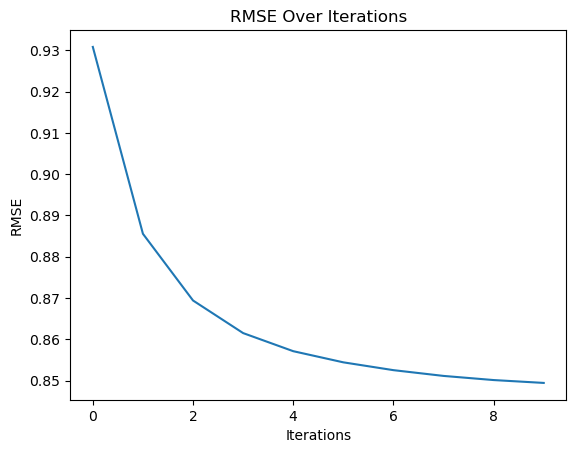

In [233]:
lambdaa=0.01
gamma=0.001
tau=0.1
k=10

U, V, user_biases, item_biases, RMSES,costs = train_model(iterations=10, n=n, m=m, k=k, train_data_by_user_index=train_data_by_user_index, train_data_by_movie_index=train_data_by_movie_index, test_data_by_user_index=test_data_by_user_index, map_movie_to_index=map_movie_to_index, map_user_to_index=map_user_to_index, lambdaa=lambdaa, gamma=gamma, tau=tau)
